# 0.0 - Imports

In [1]:
# import math
# import pickle
# import optuna
# import itertools

# import numpy                                 as np
# import pandas                                as pd
# import seaborn                               as sns
# import matplotlib.pyplot                     as plt
# import plotly.express                        as px
     
# from datetime                                import datetime
# from prophet                                 import Prophet
# from pandas.api.types                        import CategoricalDtype
# from prophet                                 import Prophet
# from prophet.plot                            import plot_plotly, plot_components_plotly, plot_cross_validation_metric
# from sklearn.metrics                         import mean_squared_error, mean_absolute_error
# from sklearn.impute                          import SimpleImputer
# from prophet.diagnostics                     import cross_validation, performance_metrics
# from sklearn.preprocessing                   import MinMaxScaler
# from xgboost                                 import XGBRegressor, plot_importance
# from sklearn.metrics                         import make_scorer, mean_squared_error, mean_absolute_error
# from sklearn.model_selection                 import cross_validate
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from keras.models                            import Sequential
# from keras.layers                            import GRU, Dense, Dropout
# from tensorflow.keras.callbacks              import EarlyStopping





In [2]:
import warnings

import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import matplotlib.pyplot        as plt

from IPython.display            import display, HTML
from datetime                   import datetime
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import MinMaxScaler
from tensorflow.keras.models    import Sequential
from tensorflow.keras.layers    import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics            import mean_squared_error, mean_absolute_error
from pandas.plotting            import register_matplotlib_converters
from statsmodels.tsa.seasonal   import seasonal_decompose

# 0.1 - Helper Functions

In [3]:
# Set the width of the container
display(HTML("<style>.container { width:100% !important; }</style>"))

# Adjust the output area for better display without causing overlap
display(HTML("""
<style>
.output {
    display: block;
    width: 100% !important;
    max-height: 1000px !important;
    overflow-y: auto;
}
.output_area {
    width: 100% !important;
    max-height: 1000px !important;
}
</style>
"""))


warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

def create_features(df):
    df = df.copy()    
    df['hour'] = df['Data_Hora'].dt.hour.astype('int64')
    df['dayofweek'] = df['Data_Hora'].dt.dayofweek.astype('int64')
    df['quarter'] = df['Data_Hora'].dt.quarter.astype('int64')
    df['month'] = df['Data_Hora'].dt.month.astype('int64')
    df['year'] = df['Data_Hora'].dt.year.astype('int64')
    df['dayofyear'] = df['Data_Hora'].dt.dayofyear.astype('int64')
    df['dayofmonth'] = df['Data_Hora'].dt.day.astype('int64')
    df['weekofyear'] = df['Data_Hora'].dt.isocalendar().week.astype('int64')

    df['season'] = 'Winter'  # Default to Winter
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=3, day=20), axis=1)) & (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=6, day=21), axis=1)), 'season'] = 'Spring'
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=6, day=21), axis=1)) & (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=9, day=23), axis=1)), 'season'] = 'Summer'
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=9, day=23), axis=1)) & (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=12, day=22), axis=1)), 'season'] = 'Fall'
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=12, day=22), axis=1)) | (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=3, day=20), axis=1)), 'season'] = 'Winter'
    
    season_map = {'Winter': 4, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    df['season'] = df['season'].map(season_map).astype('int64')
    
    return df

# 0.1 - Data

In [4]:
dfs = []

for i in range(2002, 2019):
    file = rf"C:\Users\gfurt\Ciência de dados\Séries temporais\inmet_prophet\Dados\INMET_SE_RJ_A601_ECOLOGIA AGRICOLA_01-01-{i}_A_31-12-{i}.csv"
    df = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';', skiprows=8)
    dfs.append(df)
    
df_raw_1 = pd.concat(dfs, ignore_index=True)

In [5]:
cols = df_raw_1.columns
dfs = []

for i in range(2019, 2024):
    file = rf"C:\Users\gfurt\Ciência de dados\Séries temporais\inmet_prophet\Dados\INMET_SE_RJ_A601_SEROPEDICA-ECOLOGIA AGRICOLA_01-01-{i}_A_31-12-{i}.csv"
    df = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';', skiprows=9,
                     names=cols)
    dfs.append(df)
    
df_raw_2 = pd.concat(dfs, ignore_index=True)

In [6]:
df_raw_2['HORA (UTC)'] = df_raw_2['HORA (UTC)'].str[:4]
df_raw_2['HORA (UTC)'] = df_raw_2['HORA (UTC)'].apply(lambda x: datetime.strptime(x, '%H%M').strftime('%H:%M'))

In [7]:
# Convertendo a coluna 'DATA (YYYY-MM-DD)' em df_raw_1 para datetime
df_raw_1['DATA (YYYY-MM-DD)'] = pd.to_datetime(df_raw_1['DATA (YYYY-MM-DD)'])

# Convertendo a coluna 'DATA (YYYY-MM-DD)' em df_raw_2 para datetime
df_raw_2['DATA (YYYY-MM-DD)'] = pd.to_datetime(df_raw_2['DATA (YYYY-MM-DD)'])

In [8]:
df_raw = pd.concat([df_raw_1, df_raw_2], ignore_index=True)

# 1.0 - Data description

In [9]:
df1 = df_raw.copy()

## 1.1 - Data dimensions

In [10]:
df1.shape

(192840, 20)

## 1.2 - Data Type

In [11]:
df1.dtypes

DATA (YYYY-MM-DD)                                        datetime64[ns]
HORA (UTC)                                                       object
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                                 object
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)            object
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)                  object
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)                 object
RADIACAO GLOBAL (KJ/m²)                                          object
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                     object
TEMPERATURA DO PONTO DE ORVALHO (°C)                             object
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                       object
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                       object
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)                 object
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)                 object
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        

In [12]:
columns = df1.columns[2:-1]

for i in columns:
    df1[i] = df1[i].astype(str)
    df1[i] = df1[i].str.replace(',', '.')
    df1[i] = df1[i].astype(float)

In [13]:
df1.dtypes

DATA (YYYY-MM-DD)                                        datetime64[ns]
HORA (UTC)                                                       object
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                                float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)           float64
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)                 float64
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)                float64
RADIACAO GLOBAL (KJ/m²)                                         float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                    float64
TEMPERATURA DO PONTO DE ORVALHO (°C)                            float64
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                      float64
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                      float64
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)                float64
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)                float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        

## 1.3 - Missing Values

In [14]:
total_values = df1.shape[0]
missing_values = df1.isnull().sum()
percent_missing = (missing_values / total_values) * 100

missing_data_table = pd.DataFrame({
    'Total': total_values,
    'Missing': missing_values,
    'Percent Missing': percent_missing
})

missing_data_table['Percent Missing'] = missing_data_table['Percent Missing'].map(lambda x: f'{x:.2f}%')
missing_data_table

Total  Missing  \
DATA (YYYY-MM-DD)                                   192840        0   
HORA (UTC)                                          192840        0   
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                    192840     2296   
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARI...  192840     2196   
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)     192840     2201   
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)    192840     2201   
RADIACAO GLOBAL (KJ/m²)                             192840    20770   
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)        192840      962   
TEMPERATURA DO PONTO DE ORVALHO (°C)                192840      962   
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)          192840      969   
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)          192840      968   
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)    192840      968   
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)    192840      969   
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)            192840      968   
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)            192840      968   
UMIDADE RELATIVA DO AR, HORARIA (%)                 192840      962   
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                192840      959   
VENTO, RAJADA MAXIMA (m/s)                          192840      967   
VENTO, VELOCIDADE HORARIA (m/s)                     192840      959   
Unnamed: 19                                         192840   192840   

                                                   Percent Missing  
DATA (YYYY-MM-DD)                                            0.00%  
HORA (UTC)                                                   0.00%  
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                             1.19%  
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARI...           1.14%  
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)              1.14%  
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)             1.14%  
RADIACAO GLOBAL (KJ/m²)                                     10.77%  
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                 0.50%  
TEMPERATURA DO PONTO DE ORVALHO (°C)                         0.50%  
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                   0.50%  
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                   0.50%  
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)             0.50%  
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)             0.50%  
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                     0.50%  
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                     0.50%  
UMIDADE RELATIVA DO AR, HORARIA (%)                          0.50%  
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                         0.50%  
VENTO, RAJADA MAXIMA (m/s)                                   0.50%  
VENTO, VELOCIDADE HORARIA (m/s)                              0.50%  
Unnamed: 19                                                100.00%

## 1.4 - Descriptive statistics

In [15]:
df1.describe()

DATA (YYYY-MM-DD)  PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
count               192840                     190544.000000   
mean   2012-12-31 00:00:00                       -546.106078   
min    2002-01-01 00:00:00                      -9999.000000   
25%    2007-07-02 00:00:00                          0.000000   
50%    2012-12-31 00:00:00                          0.000000   
75%    2018-07-02 00:00:00                          0.000000   
max    2023-12-31 00:00:00                         66.200000   
std                    NaN                       2272.330083   

       PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
count                                      190644.000000       
mean                                          513.676597       
min                                         -9999.000000       
25%                                          1008.200000       
50%                                          1011.400000       
75%                                          1015.100000       
max                                          1029.700000       
std                                          2288.979966       

       PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
count                                    190639.000000   
mean                                        508.019335   
min                                       -9999.000000   
25%                                        1008.400000   
50%                                        1011.700000   
75%                                        1015.400000   
max                                        1029.700000   
std                                        2301.906344   

       PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  \
count                                     190639.000000   
mean                                         507.527419   
min                                        -9999.000000   
25%                                         1007.900000   
50%                                         1011.200000   
75%                                         1014.900000   
max                                         1029.400000   
std                                         2301.798652   

       RADIACAO GLOBAL (KJ/m²)  TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
count            172070.000000                                 191878.000000   
mean              -2646.579677                                   -426.784848   
min               -9999.000000                                  -9999.000000   
25%               -9999.000000                                     20.200000   
50%                  62.200000                                     23.100000   
75%                1246.800000                                     26.300000   
max                6300.200000                                     42.400000   
std                5294.042664                                   2076.675194   

       TEMPERATURA DO PONTO DE ORVALHO (°C)  \
count                         191878.000000   
mean                            -436.743821   
min                            -9999.000000   
25%                               16.600000   
50%                               19.200000   
75%                               21.300000   
max                               27.200000   
std                             2087.574292   

       TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  \
count                               191871.000000   
mean                                  -429.414992   
min                                  -9999.000000   
25%                                     20.600000   
50%                                     23.600000   
75%                                     27.100000   
max                                     42.600000   
std                                   2083.820176   

       TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)  \
count                               191872.000000   
mean                                  -430.425210   
min               

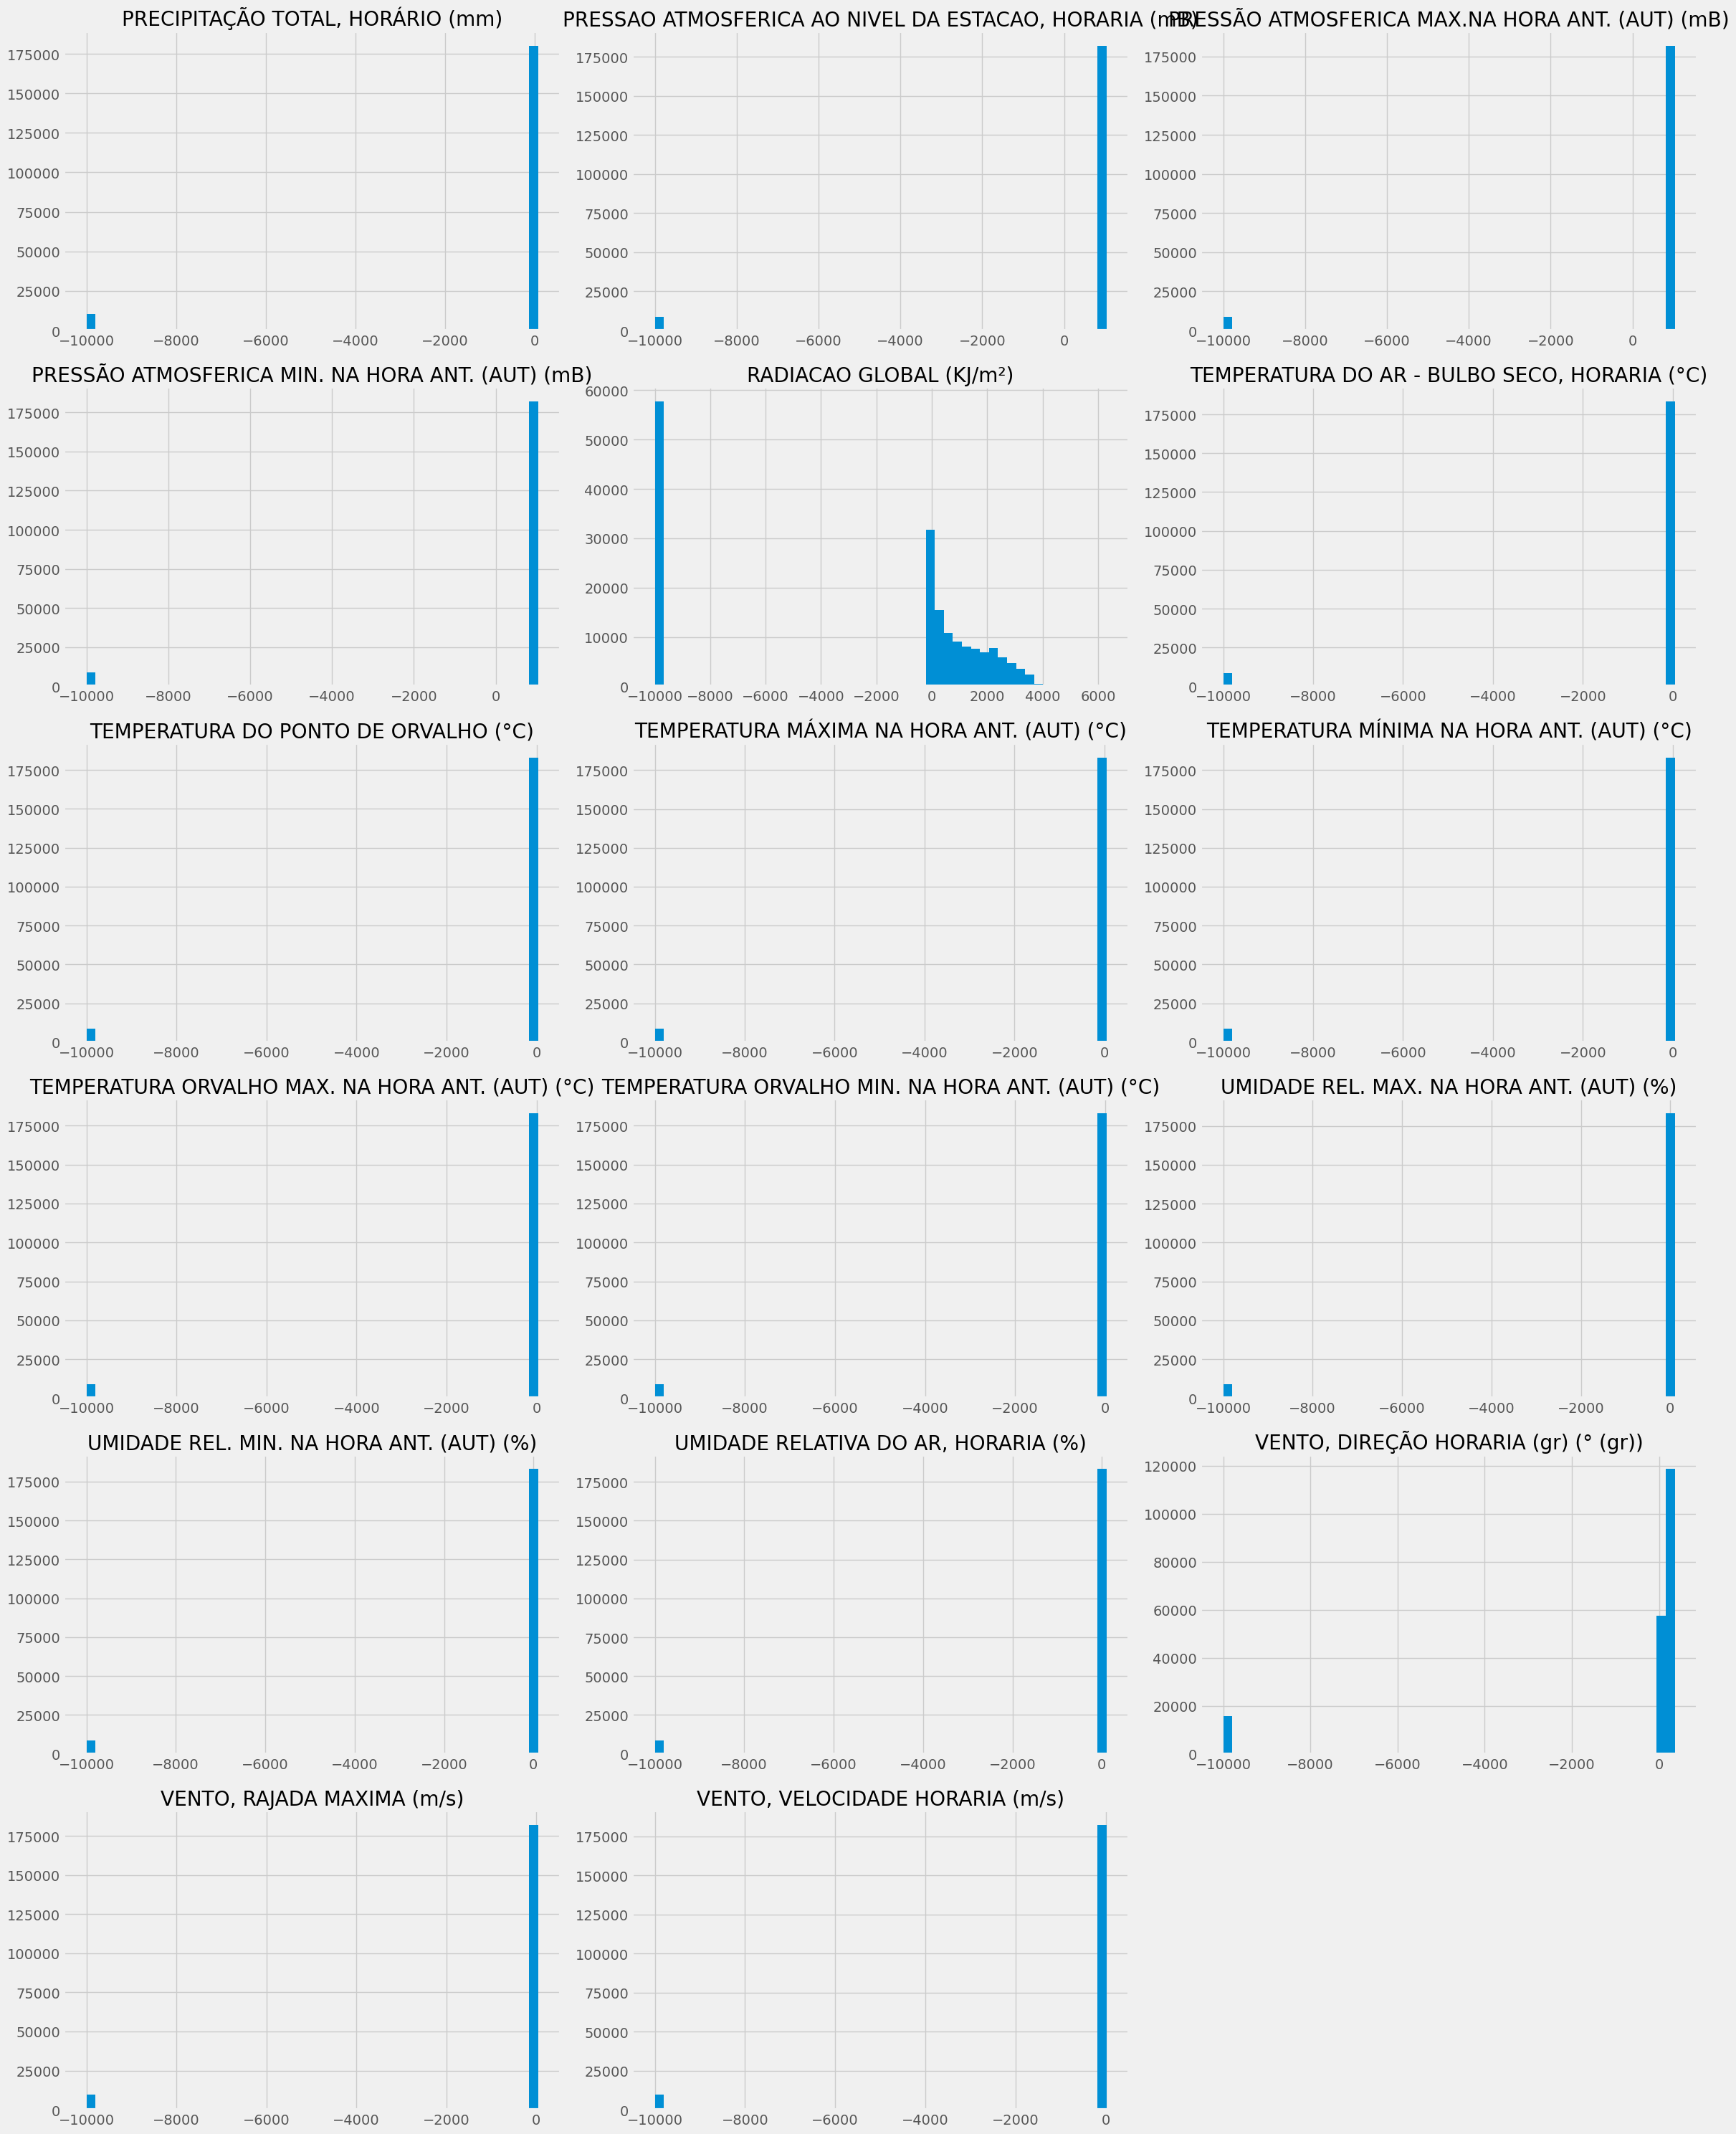

In [16]:
df_aux = df1.iloc[:,2:-1].copy()

# Definindo o número de colunas e linhas para os subplots
num_columns = len(df_aux.columns)
num_rows = (num_columns + 3) // 3  # Aproximadamente 4 colunas por linha

fig, axes = plt.subplots(num_rows, 3, figsize=(24, 5 * num_rows))  # Ajuste o tamanho da figura conforme necessário
axes = axes.flatten()  # Transformar a matriz 2D de eixos em um array 1D

for i, col in enumerate(df_aux.columns):
    df_aux[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(col)

# Remover eixos vazios se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# 2.0 - Feature engineering

In [17]:
df2 = df1.copy()

In [18]:
df2['HORA (UTC)'] = pd.to_timedelta(df2['HORA (UTC)'] + ':00')
df2['Data_Hora'] = df2['DATA (YYYY-MM-DD)'] + df2['HORA (UTC)']

df2['Data_Hora'] = pd.to_datetime(df2['Data_Hora'])

In [19]:
# creating columns 'date, hour, dayofweek, quarter, month, year, dayofyear, dayofmonth, weekofyear, season'

df2 = create_features(df2)

# 3.0 - Data Cleaning

In [20]:
df3 = df2.copy()

## 3.1 - Replace -9999 values for nan

In [21]:
df3 = df3.replace(-9999, np.nan)

## 3.2 - Removing columns

In [22]:
columns_ordered = [
    'Data_Hora', 'hour', 'dayofweek', 'quarter', 'month', 'year',
    'dayofyear', 'dayofmonth', 'weekofyear', 'season',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
]

# Reindexar o DataFrame com a ordem desejada das colunas
df3 = df3.reindex(columns=columns_ordered)

## 3.4 - Missing values

In [23]:
imputer = SimpleImputer(strategy='mean')

df3['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = imputer.fit_transform(df3[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']])

df3.isnull().sum()

Data_Hora                                       0
hour                                            0
dayofweek                                       0
quarter                                         0
month                                           0
year                                            0
dayofyear                                       0
dayofmonth                                      0
weekofyear                                      0
season                                          0
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)    0
dtype: int64

# 4.0 - Exploratory Data Analysis

In [24]:
df4 = df3.copy()

In [25]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

num_attributes.describe()

hour      dayofweek        quarter          month  \
count  192840.000000  192840.000000  192840.000000  192840.000000   
mean       11.500000       3.000373       2.508650       6.523211   
std         6.922205       1.999850       1.117057       3.448635   
min         0.000000       0.000000       1.000000       1.000000   
25%         5.750000       1.000000       2.000000       4.000000   
50%        11.500000       3.000000       3.000000       7.000000   
75%        17.250000       5.000000       4.000000      10.000000   
max        23.000000       6.000000       4.000000      12.000000   

                year      dayofyear     dayofmonth     weekofyear  \
count  192840.000000  192840.000000  192840.000000  192840.000000   
mean     2012.499689     183.113877      15.728811      26.595520   
std         6.343913     105.432327       8.799766      15.061586   
min      2002.000000       1.000000       1.000000       1.000000   
25%      2007.000000      92.000000       8.000000      14.000000   
50%      2012.000000     183.000000      16.000000      27.000000   
75%      2018.000000     274.000000      23.000000      40.000000   
max      2023.000000     366.000000      31.000000      53.000000   

              season  TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  
count  192840.000000                                 192840.000000  
mean        2.474922                                     23.741777  
std         1.114354                                      4.415548  
min         1.000000                                      8.600000  
25%         1.000000                                     20.800000  
50%         2.000000                                     23.600000  
75%         3.000000                                     26.300000  
max         4.000000                                     42.400000

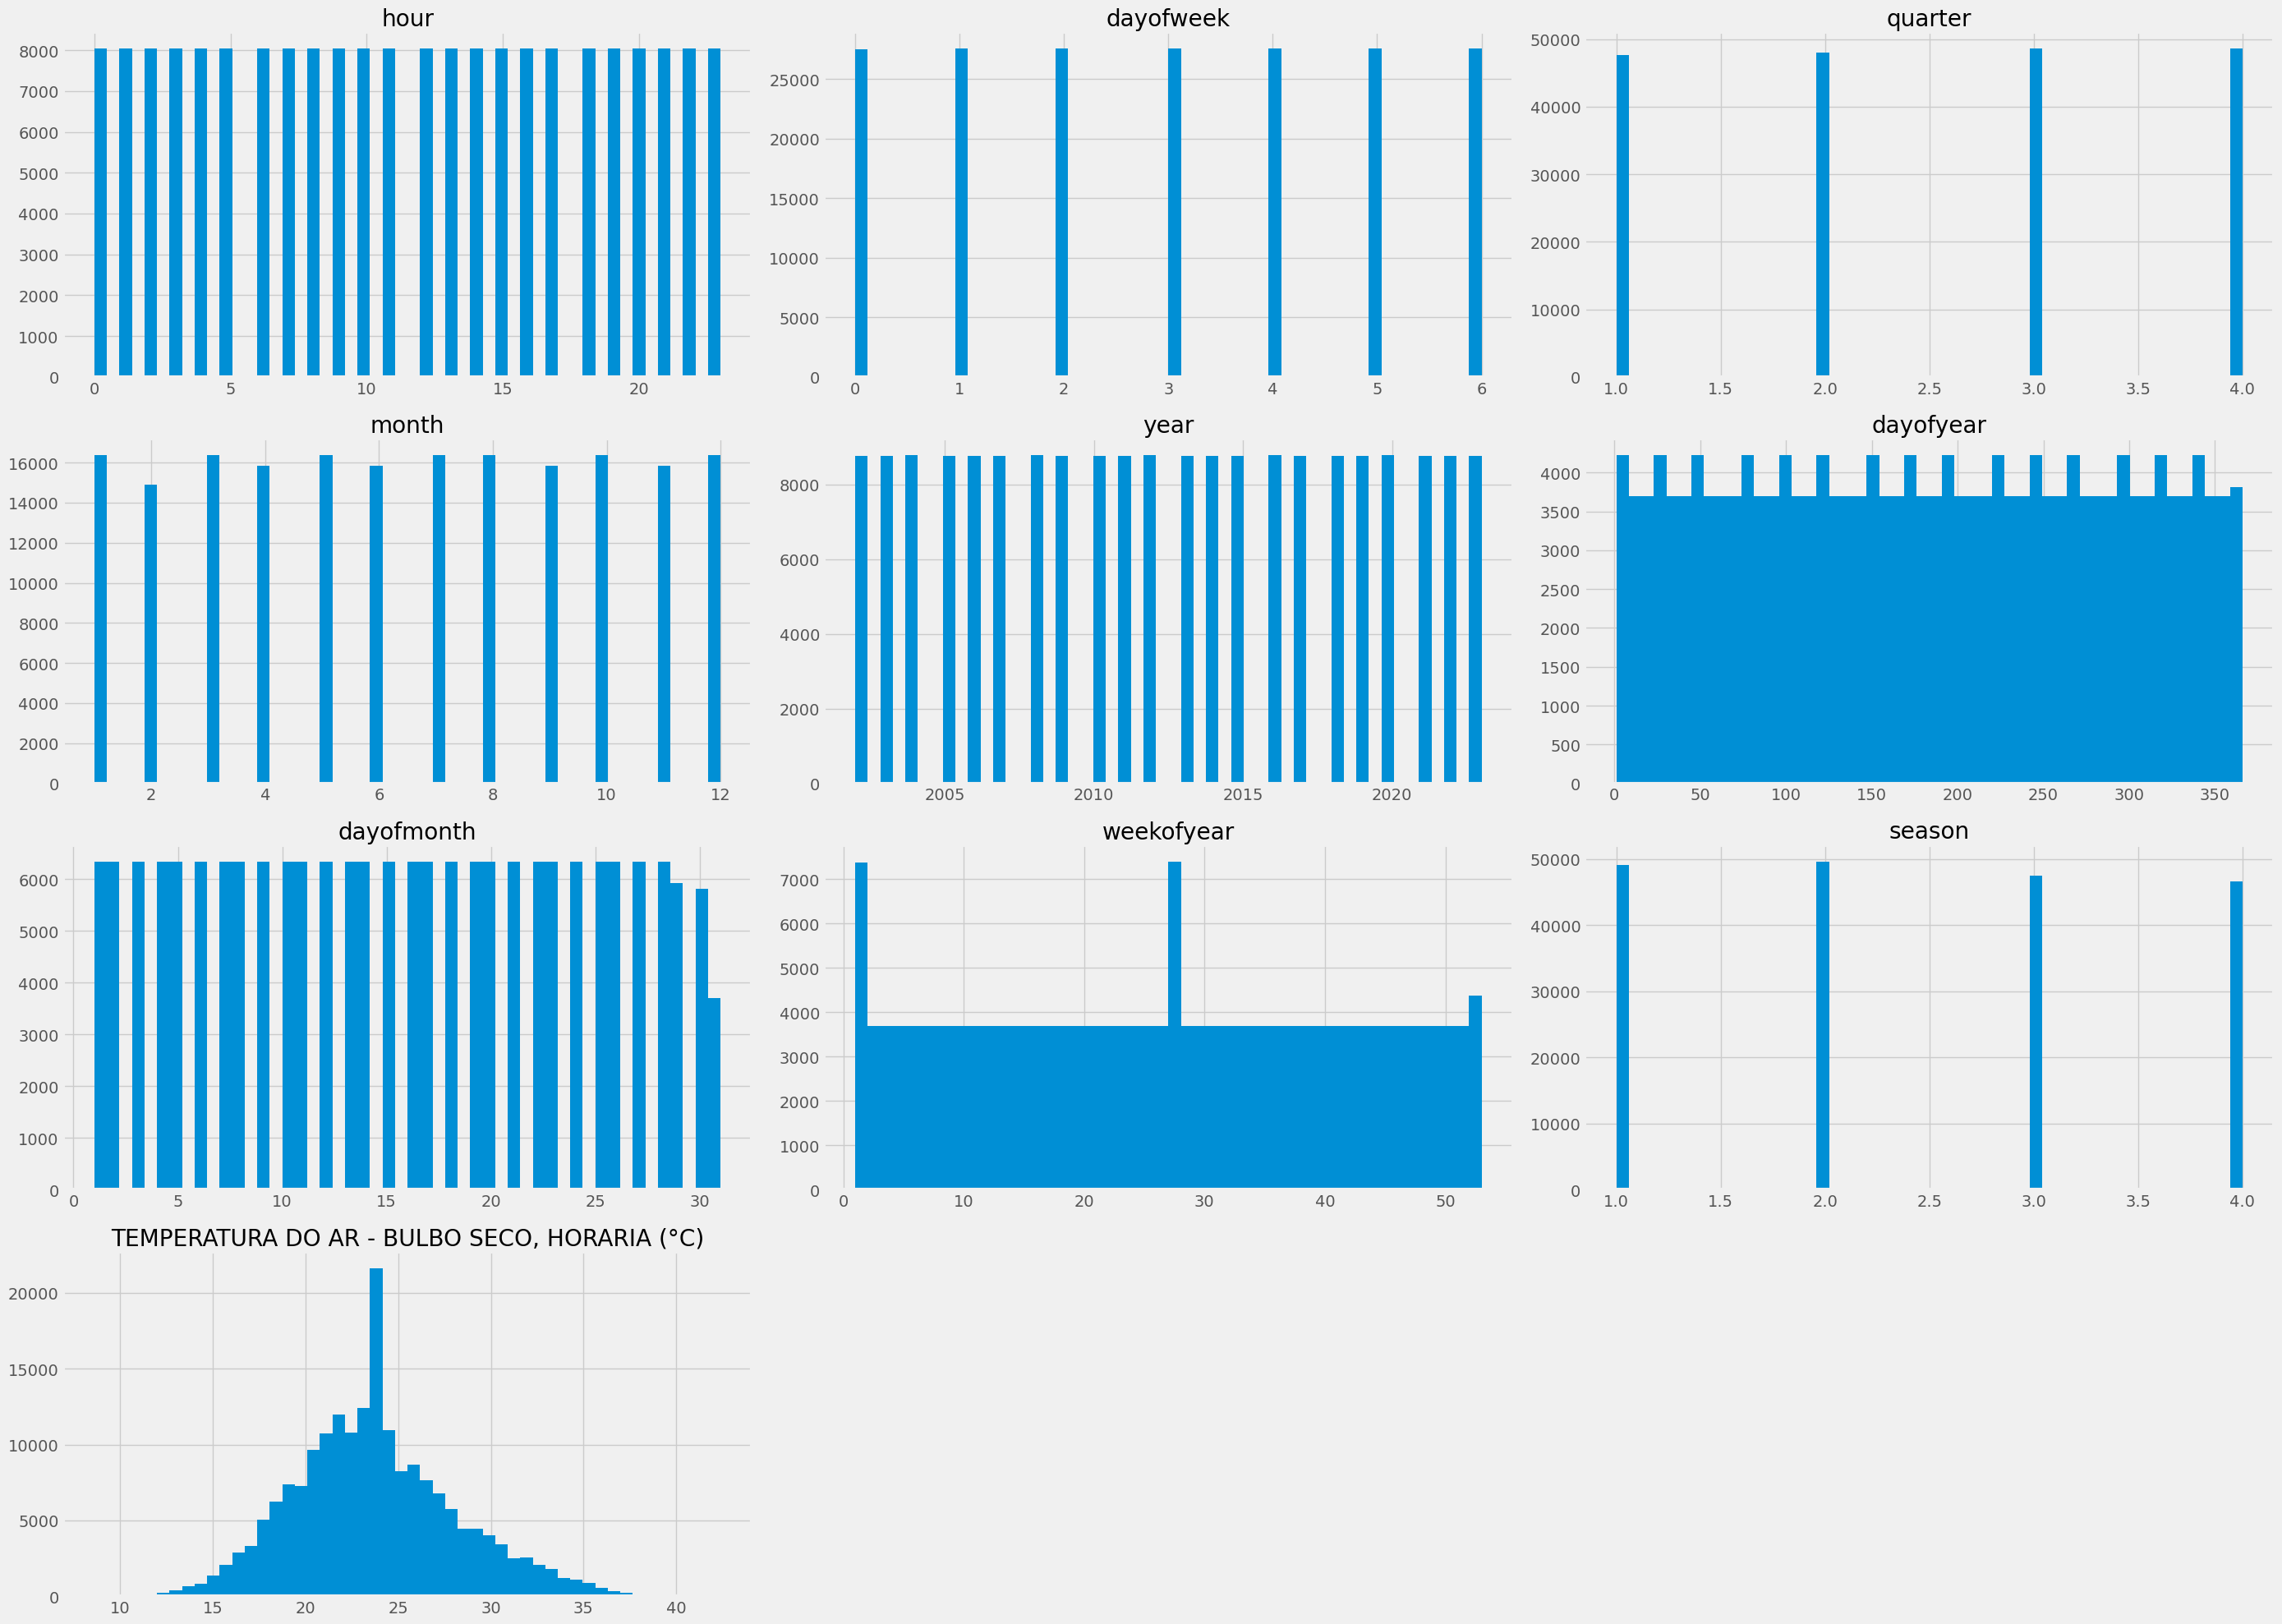

In [26]:
num_columns = len(num_attributes.columns)
num_rows = (num_columns + 3) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(28, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(num_attributes.columns):
    num_attributes[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 4.1 - Univariate Analysis

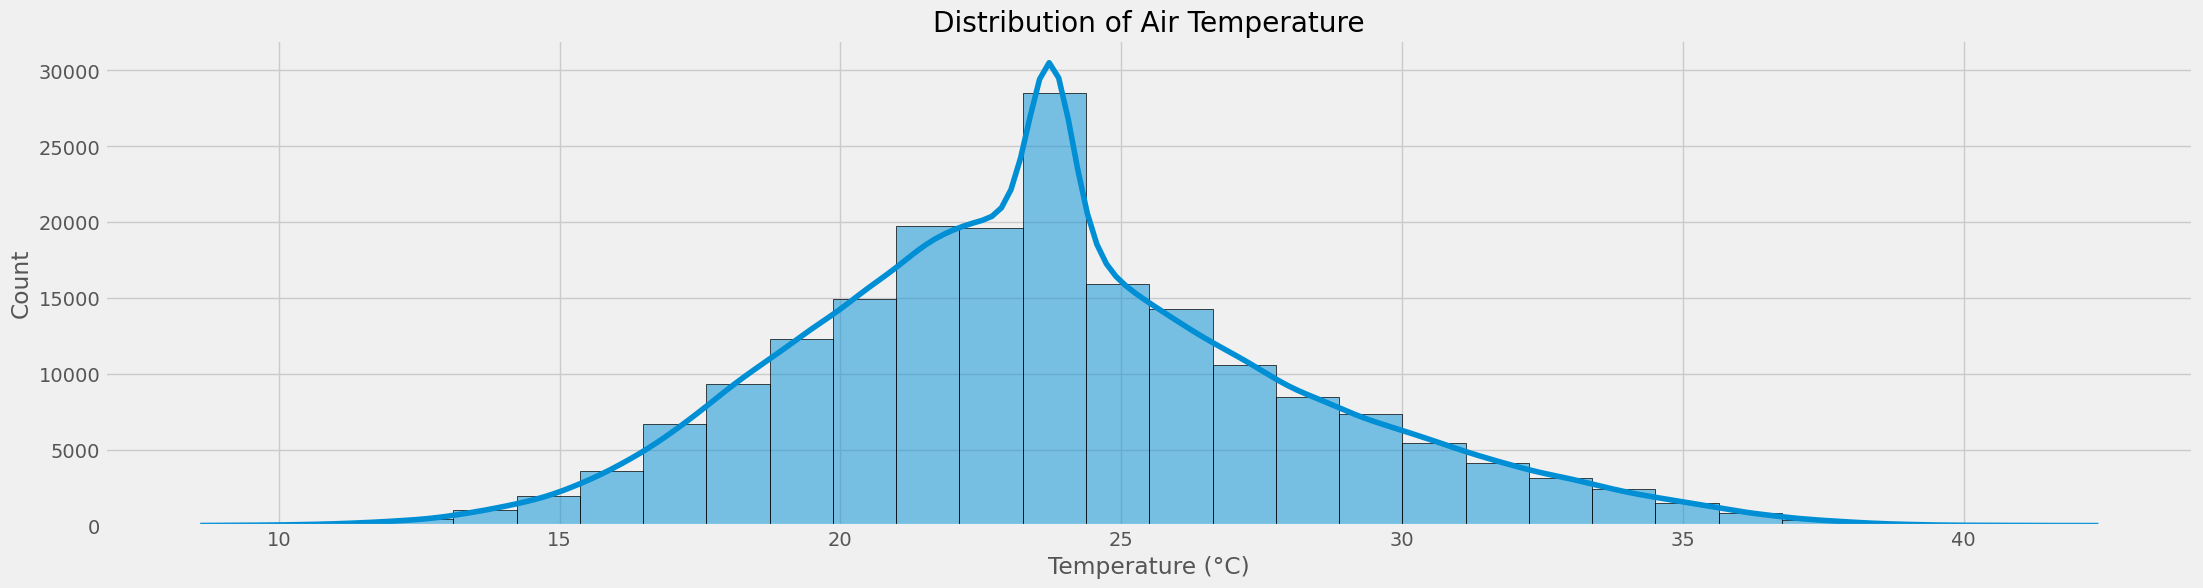

In [27]:
plt.figure(figsize=(24, 6))
sns.histplot(df4['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], bins=30, kde=True, edgecolor='black')
plt.title('Distribution of Air Temperature')
plt.xlabel('Temperature (°C)')
plt.show()

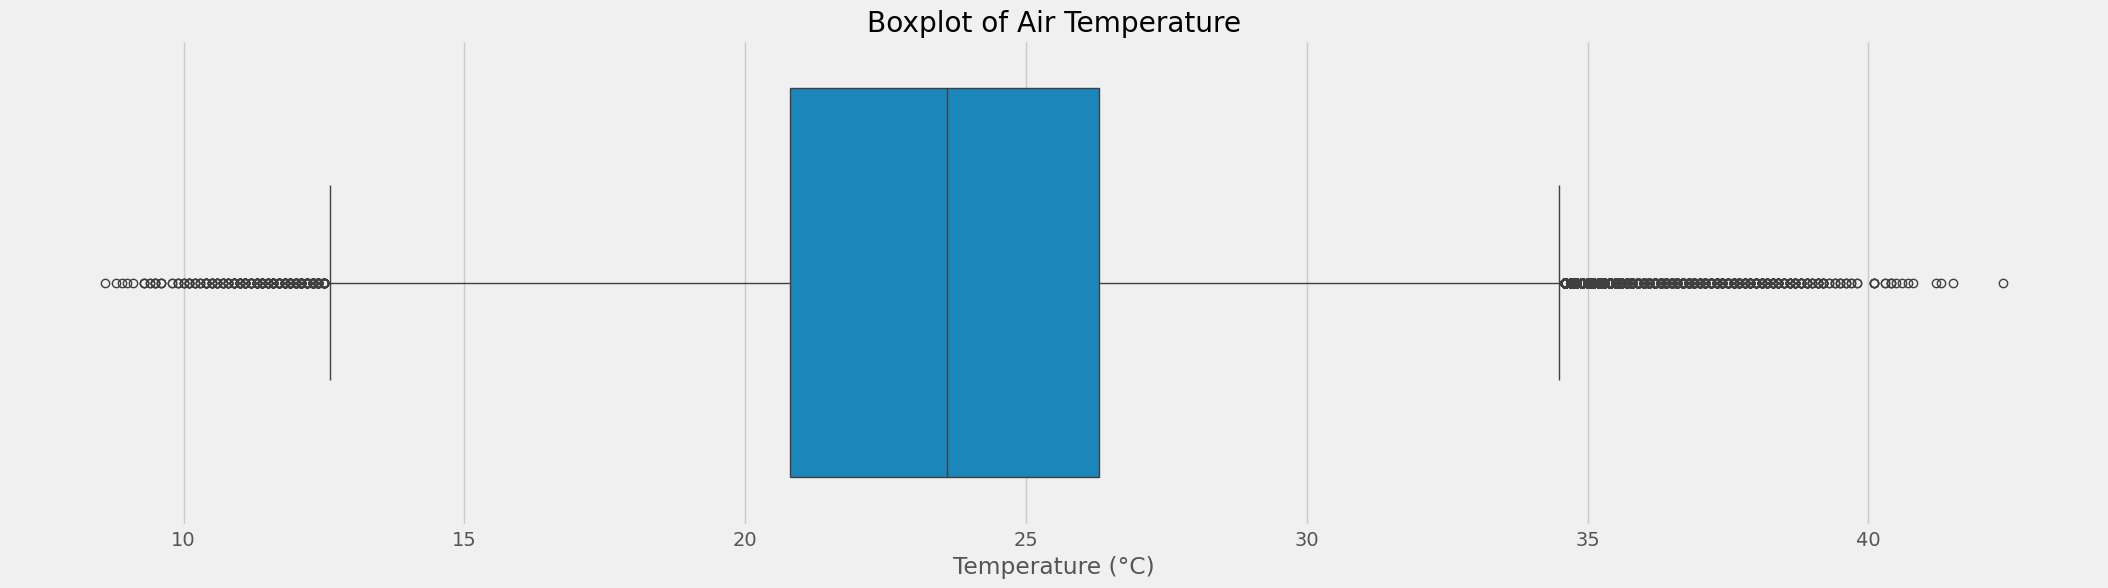

In [28]:
plt.figure(figsize=(24, 6))
sns.boxplot(x=df4['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'])
plt.title('Boxplot of Air Temperature')
plt.xlabel('Temperature (°C)')

plt.show()


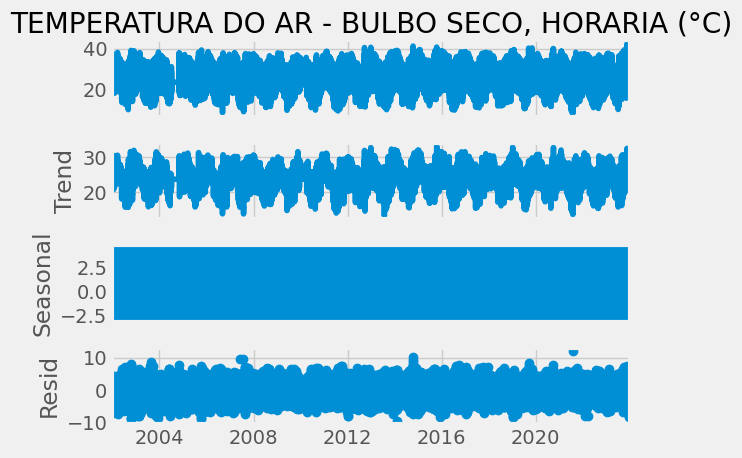

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_aux = df4.copy()
df_aux.set_index('Data_Hora', inplace=True)
df_aux = df_aux.asfreq('H')

# Realizar a decomposição sazonal
result = seasonal_decompose(df_aux['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], model='additive', period=24)

# Plotar os resultados da decomposição
result.plot();

## 4.2 - Bivariate Analysis

### 4.2.1 - Temperature x Year

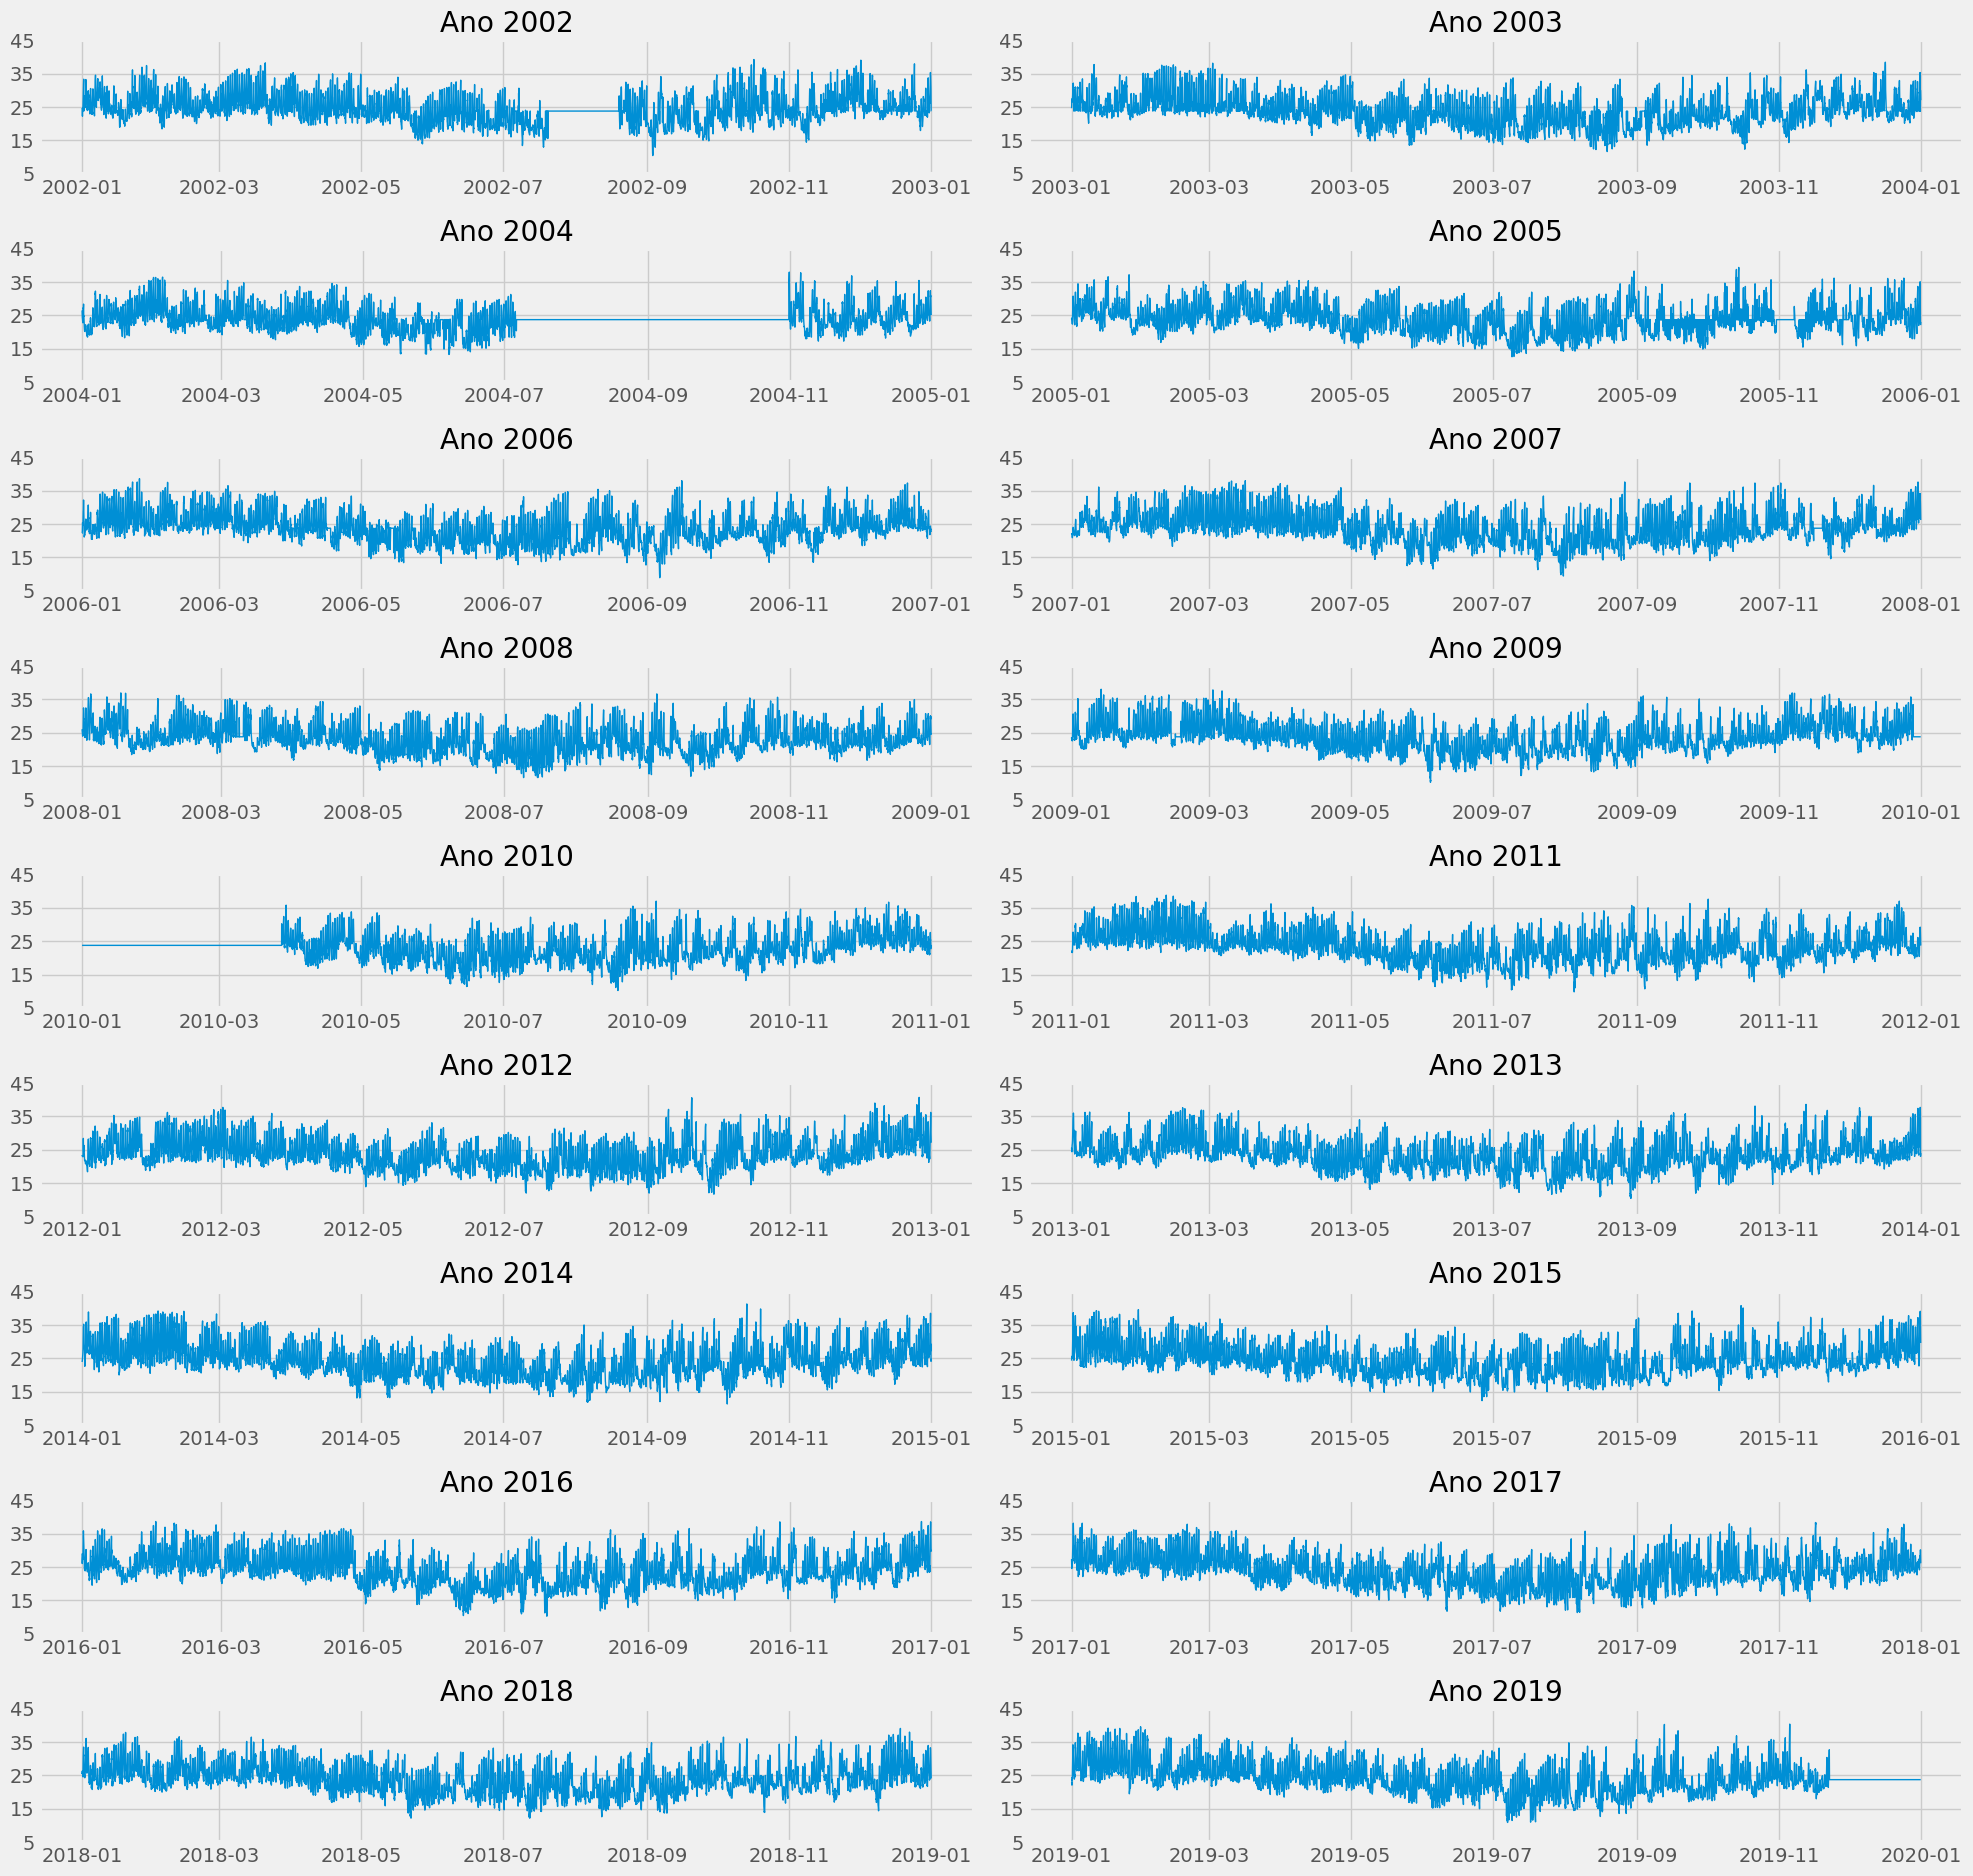

In [30]:
plt.figure(figsize=(20, 25))
for i, year in enumerate(range(2002, 2020), start=1):
    plt.subplot(12, 2, i)
    sns.lineplot(data=df4[df4['year'] == year], x='Data_Hora', y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)', linewidth=1)
    plt.title(f'Ano {year}')
    plt.yticks([5, 15, 25, 35, 45]) 
    plt.ylabel('')
    plt.xlabel('')
    
    
plt.tight_layout()
plt.show()

### 4.2.2 - Temperature x Week of Year

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


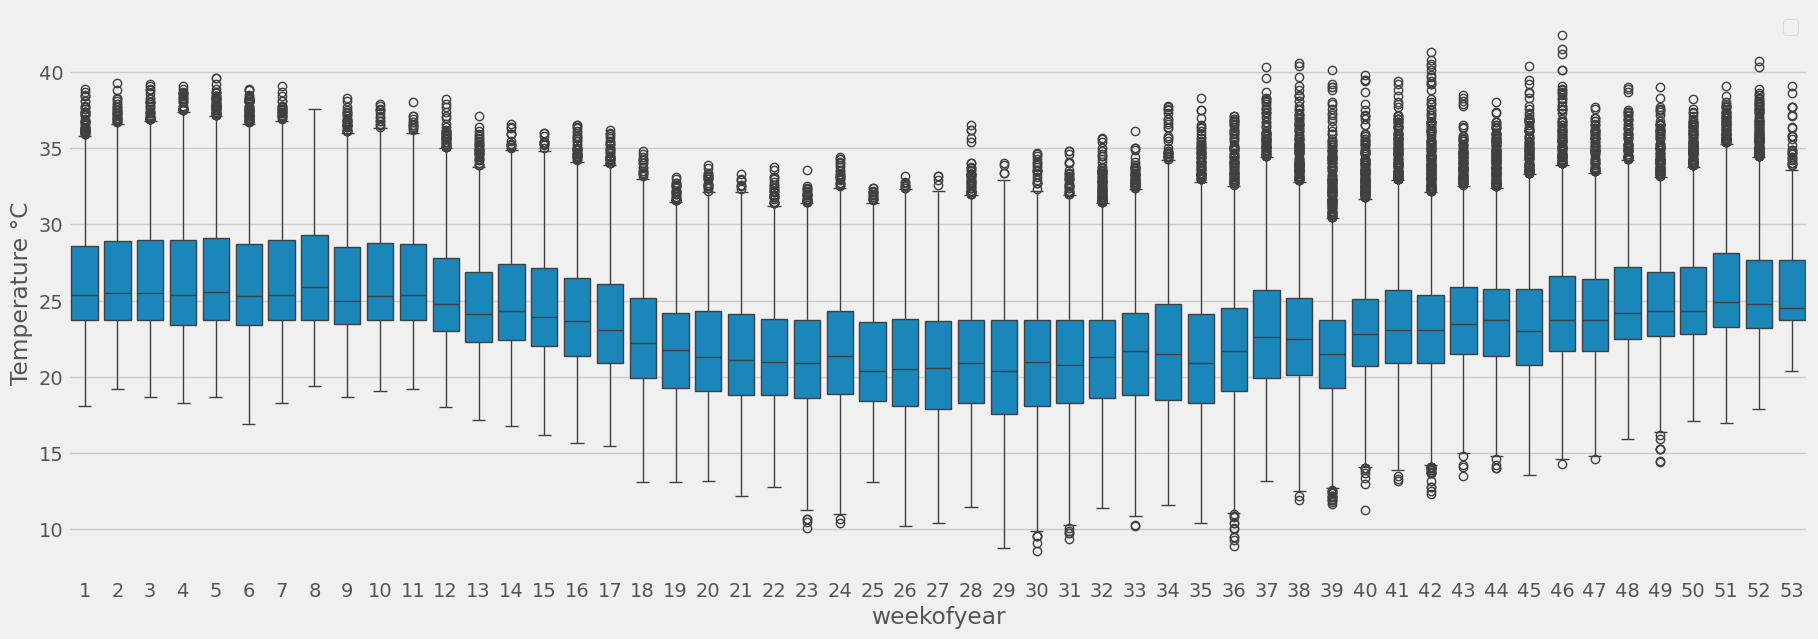

In [31]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4,
           x='weekofyear', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           ax=ax,
           linewidth=1)

ax.set_ylabel('Temperature °C')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### 4.2.3 - Temperature x Season

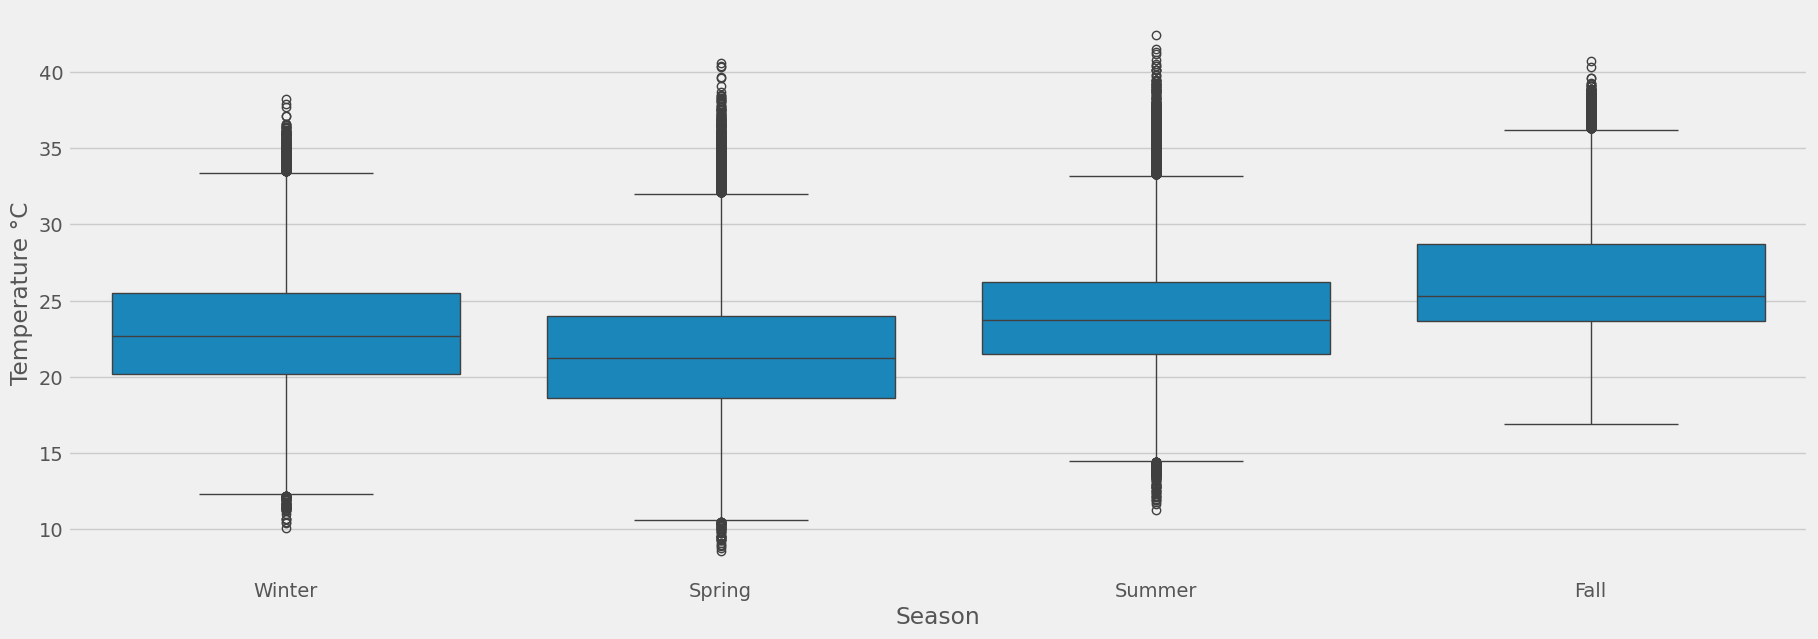

In [32]:
season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}

fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4.dropna(),
           x='season', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           ax=ax,
           linewidth=1)


ax.set_xlabel('Season')
ax.set_ylabel('Temperature °C')

ax.set_xticklabels([season_map.get(x, x) for x in df4['season'].unique()])

plt.show()

### 4.2.4 - Temperature x Time of Day

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


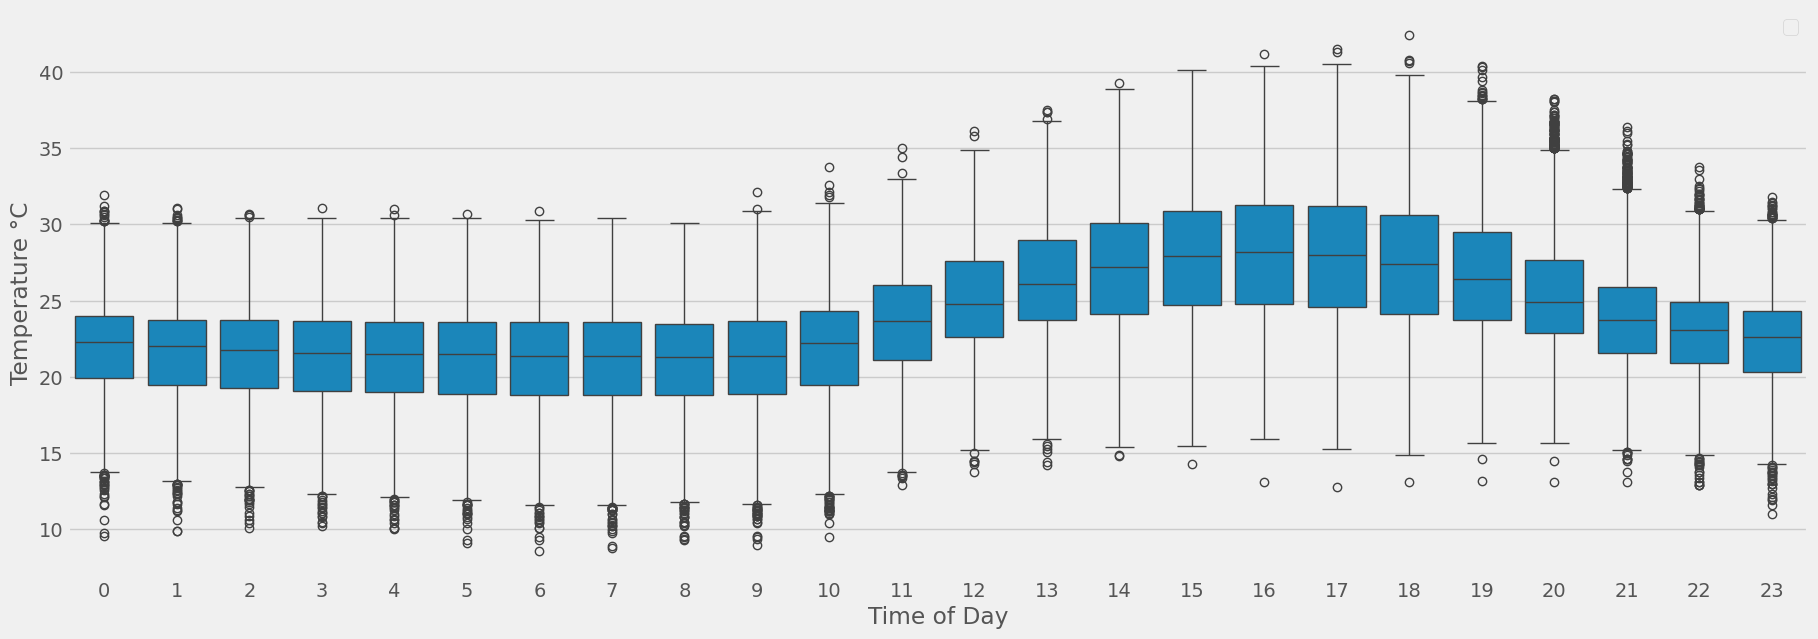

In [33]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4.dropna(),
           x='hour', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           ax=ax,
           linewidth=1)

ax.set_xlabel('Time of Day')
ax.set_ylabel('Temperature °C')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## 4.3 - Multivariate Analysis

### 4.3.1 - Temperature x Time of day - By Season

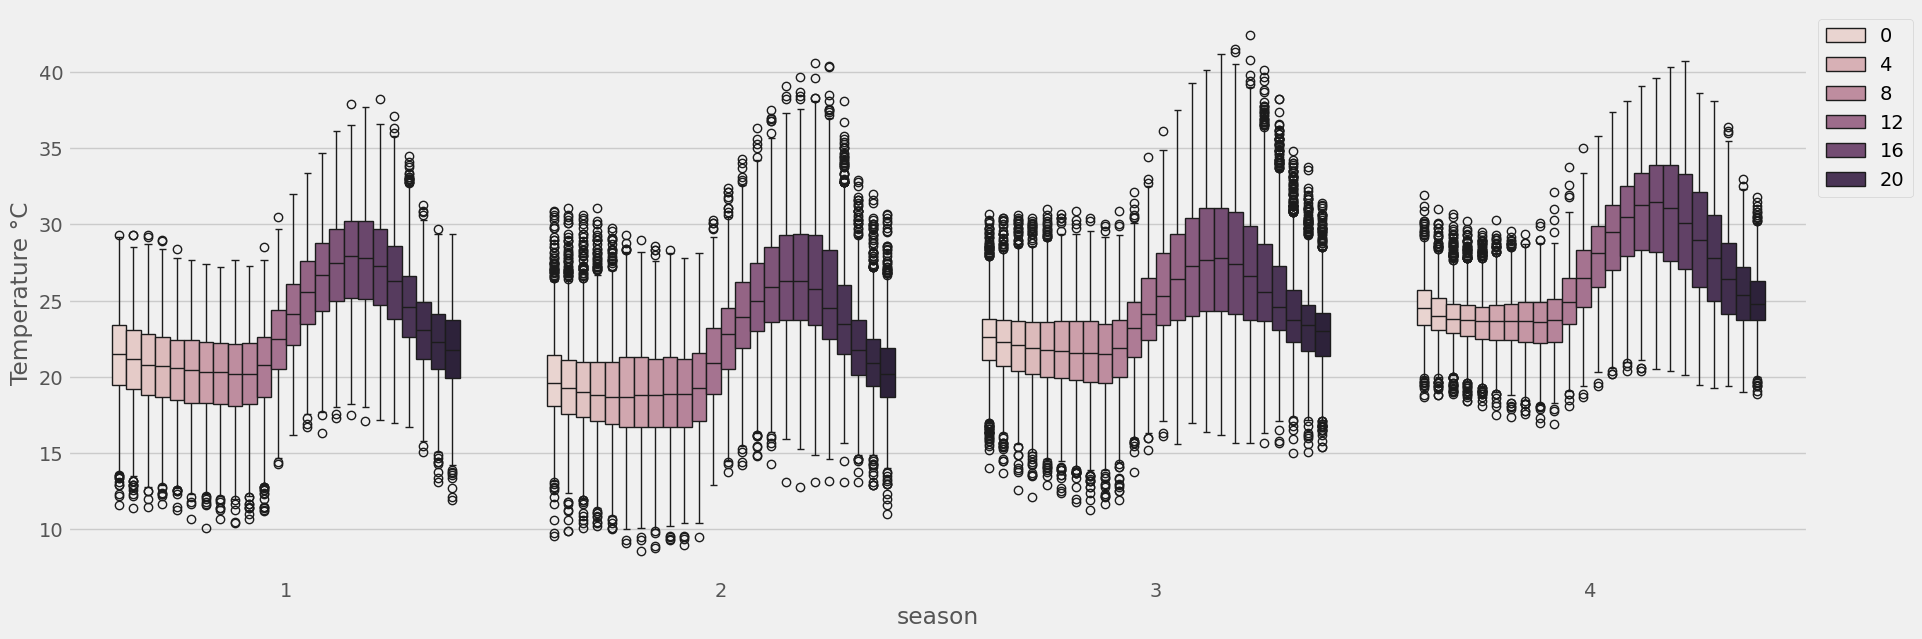

In [34]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4.dropna(),
           x='season', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           hue='hour',
           ax=ax,
           linewidth=1)

ax.set_ylabel('Temperature °C')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### 4.3.2 - Temperature x Year -  By Season

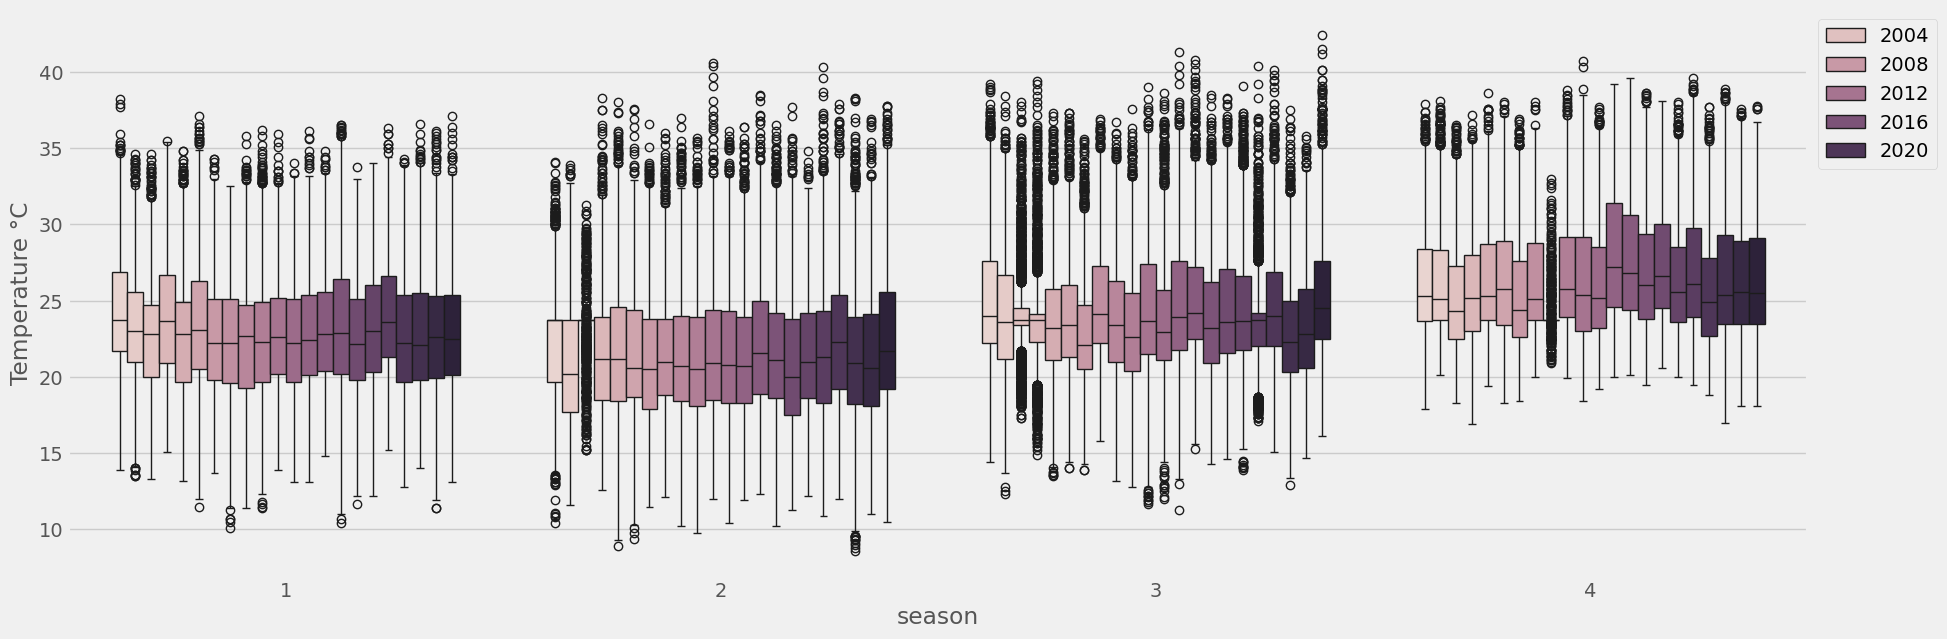

In [35]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4.dropna(),
           x='season', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           hue='year',
           ax=ax,
           linewidth=1)


ax.set_ylabel('Temperature °C')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### 4.3.3 - Heatmap

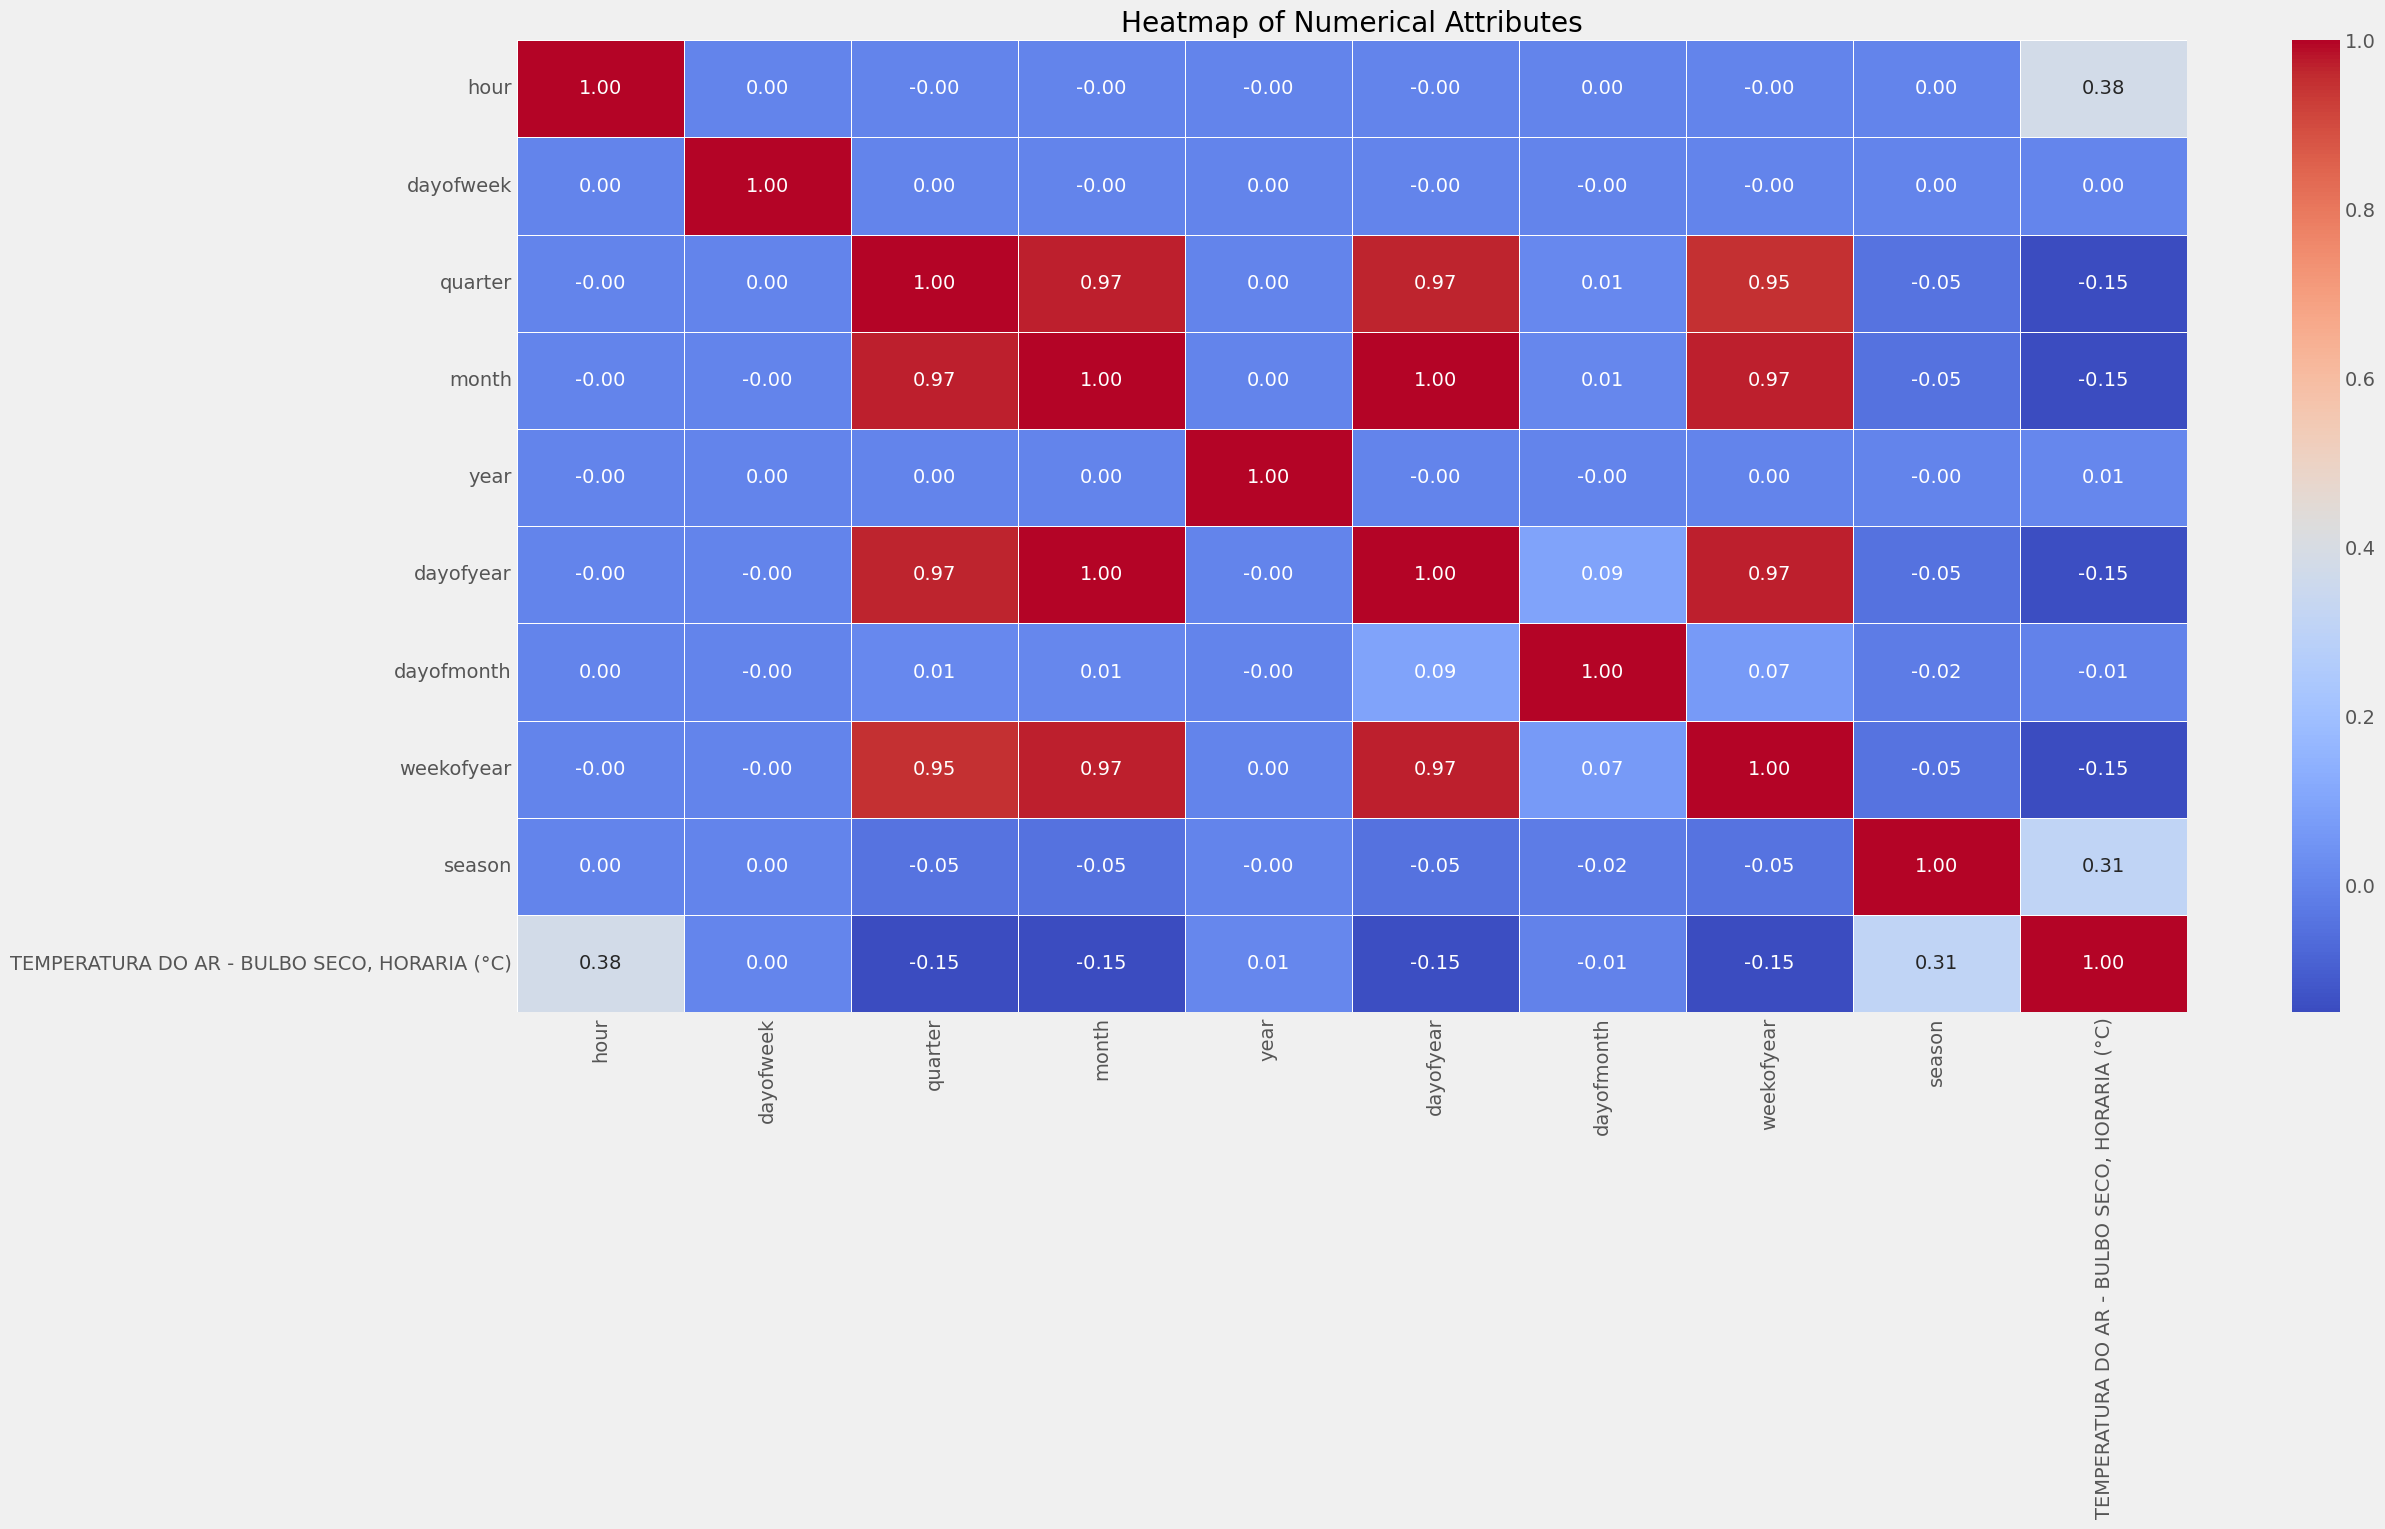

In [36]:
correlation_matrix = num_attributes.corr()


plt.figure(figsize=(24, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Numerical Attributes')
plt.show()

# 5.0 - Data Preparation

In [37]:
df5 = df4.copy()

In [38]:
df5 = df5.set_index('Data_Hora')

In [39]:
mms = MinMaxScaler()

df5['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = mms.fit_transform(df5[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']])

# 6.0 - Feature Selection

In [40]:
df6 = df5.copy()

In [41]:
df6 = df6[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']].copy()

In [42]:
train = df6.loc[df6.index < '2019-01-01']
test = df6.loc[df6.index >= '2019-01-01']

In [43]:
def create_sequences(data, n_input):
    sequences = []
    labels = []
    for i in range(len(data) - n_input):
        seq = data[i:i+n_input]
        label = data[i+n_input]
        sequences.append(seq)
        labels.append(label)
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels


In [44]:
n_input = 24
X_train, y_train = create_sequences(train['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].values, n_input)
X_test, y_test = create_sequences(test['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].values, n_input)

In [45]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 7.0 - Machine Learning

In [46]:
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(n_input, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [48]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 0.0112 - val_loss: 0.0011
Epoch 2/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0018 - val_loss: 9.7237e-04
Epoch 3/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 4/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - loss: 0.0016 - val_loss: 9.4830e-04
Epoch 5/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - loss: 0.0016 - val_loss: 9.8997e-04
Epoch 6/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - loss: 0.0016 - val_loss: 9.8914e-04
Epoch 7/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0015 - val_loss: 9.5269e-04
Epoch 8/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - loss: 0.0015 - val_loss: 9.9952e-04
Epoch 9/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - loss: 0.0015 - val_loss: 9.7258e-04
Epoch 10/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - loss: 0.0015 - val_loss: 9.5600e-04
Epoch 11/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 0.

# 8.0 - Model Evaluation

In [57]:
predictions = model.predict(X_test)

predictions_rescaled = mms.inverse_transform(predictions)
y_test_rescaled = mms.inverse_transform(y_test.reshape(-1, 1))

1369/1369 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


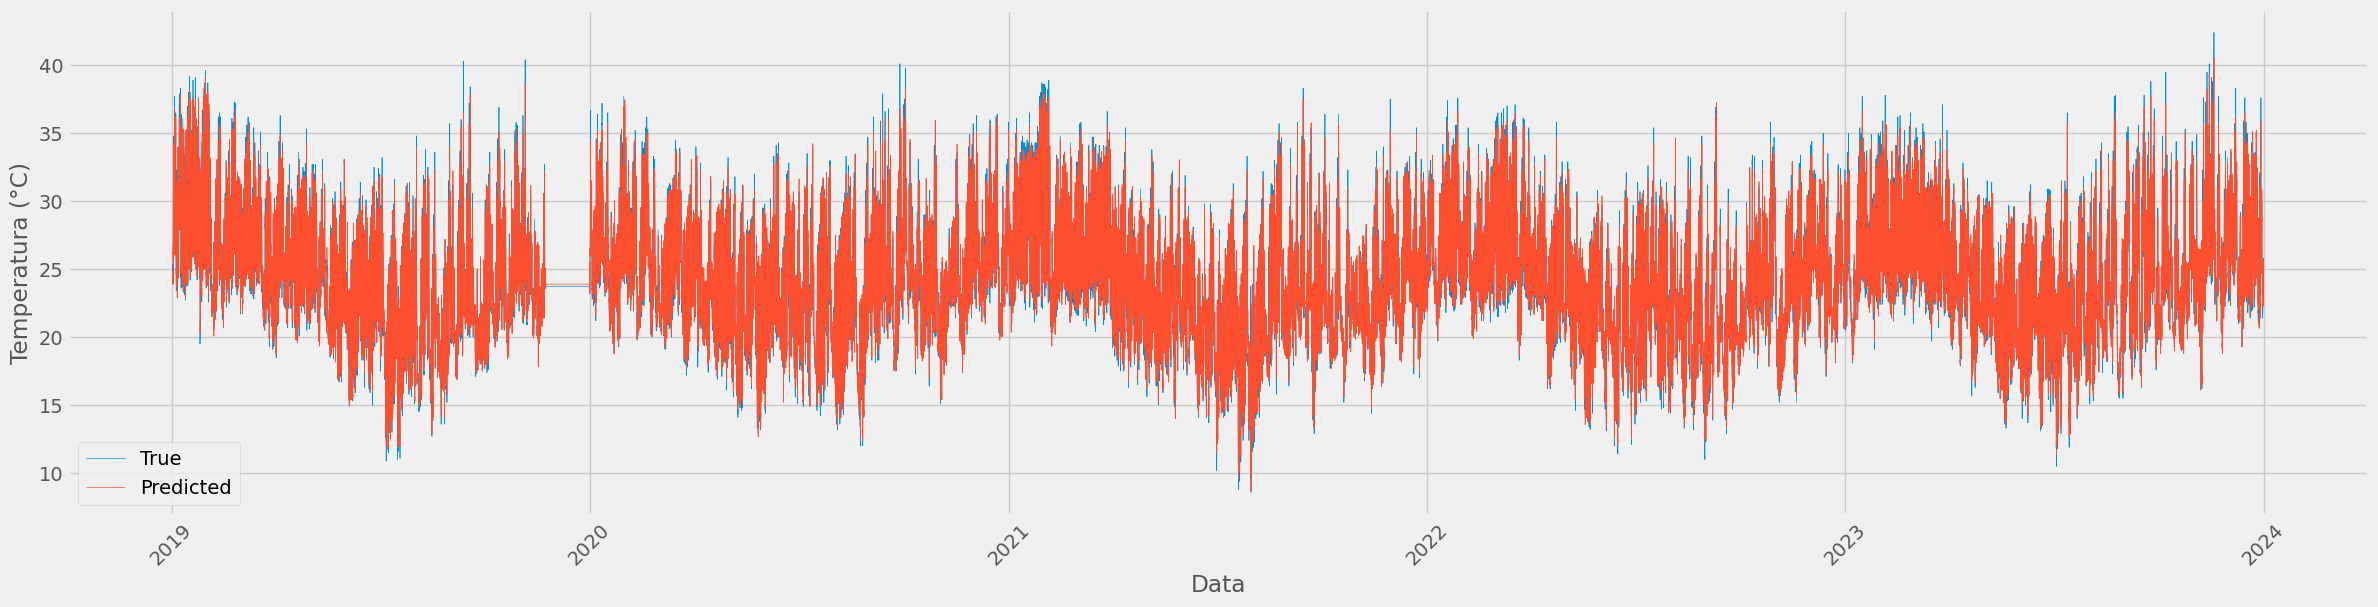

In [58]:
dates = df6.index[-len(y_test_rescaled):]  # Últimas datas correspondentes aos dados de teste

plt.figure(figsize=(24, 6))  # Ajuste aqui o tamanho (largura, altura)

# Plota os dados reais e previstos com datas como rótulos do eixo x
plt.plot(dates, y_test_rescaled, label='True', linewidth=0.5)
plt.plot(dates, predictions_rescaled, label='Predicted', linewidth=0.5)

plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

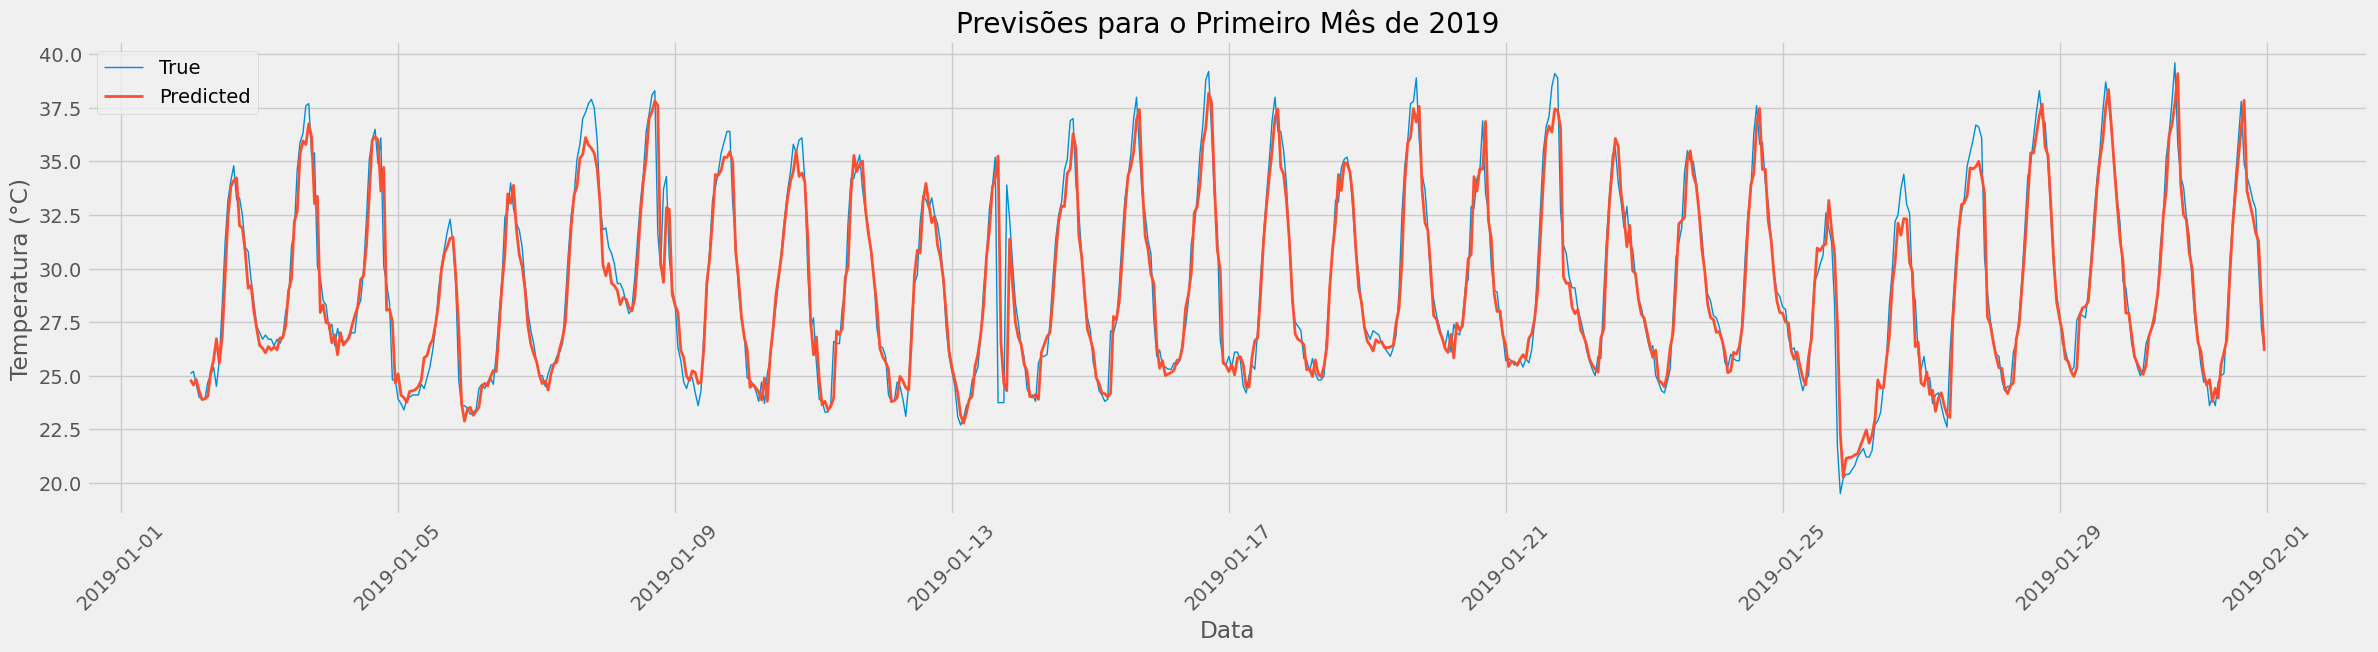

In [59]:
# Filtrando os dados de teste e as datas para o primeiro mês de 2019
mask = (dates >= '2019-01-01') & (dates < '2019-02-01')
dates_filtered = dates[mask]
y_test_filtered = y_test_rescaled[mask]
predictions_filtered = predictions_rescaled[mask]

# Plotando o gráfico para o primeiro mês de 2019
plt.figure(figsize=(24, 6))  # Ajuste aqui o tamanho (largura, altura)

plt.plot(dates_filtered, y_test_filtered, label='True', linewidth=1)
plt.plot(dates_filtered, predictions_filtered, label='Predicted', linewidth=2)

plt.xlabel('Data')  # Definindo o rótulo do eixo x como 'Data'
plt.ylabel('Temperatura (°C)')  # Definindo o rótulo do eixo y como 'Temperatura (°C)'
plt.title('Previsões para o Primeiro Mês de 2019')  # Adicionando um título ao gráfico
plt.legend()  # Mostrando a legenda
plt.tight_layout()  # Ajustando o layout para evitar que os rótulos se sobreponham
plt.xticks(rotation=45)  # Rotacionando os rótulos do eixo x para melhor visualização

plt.show()


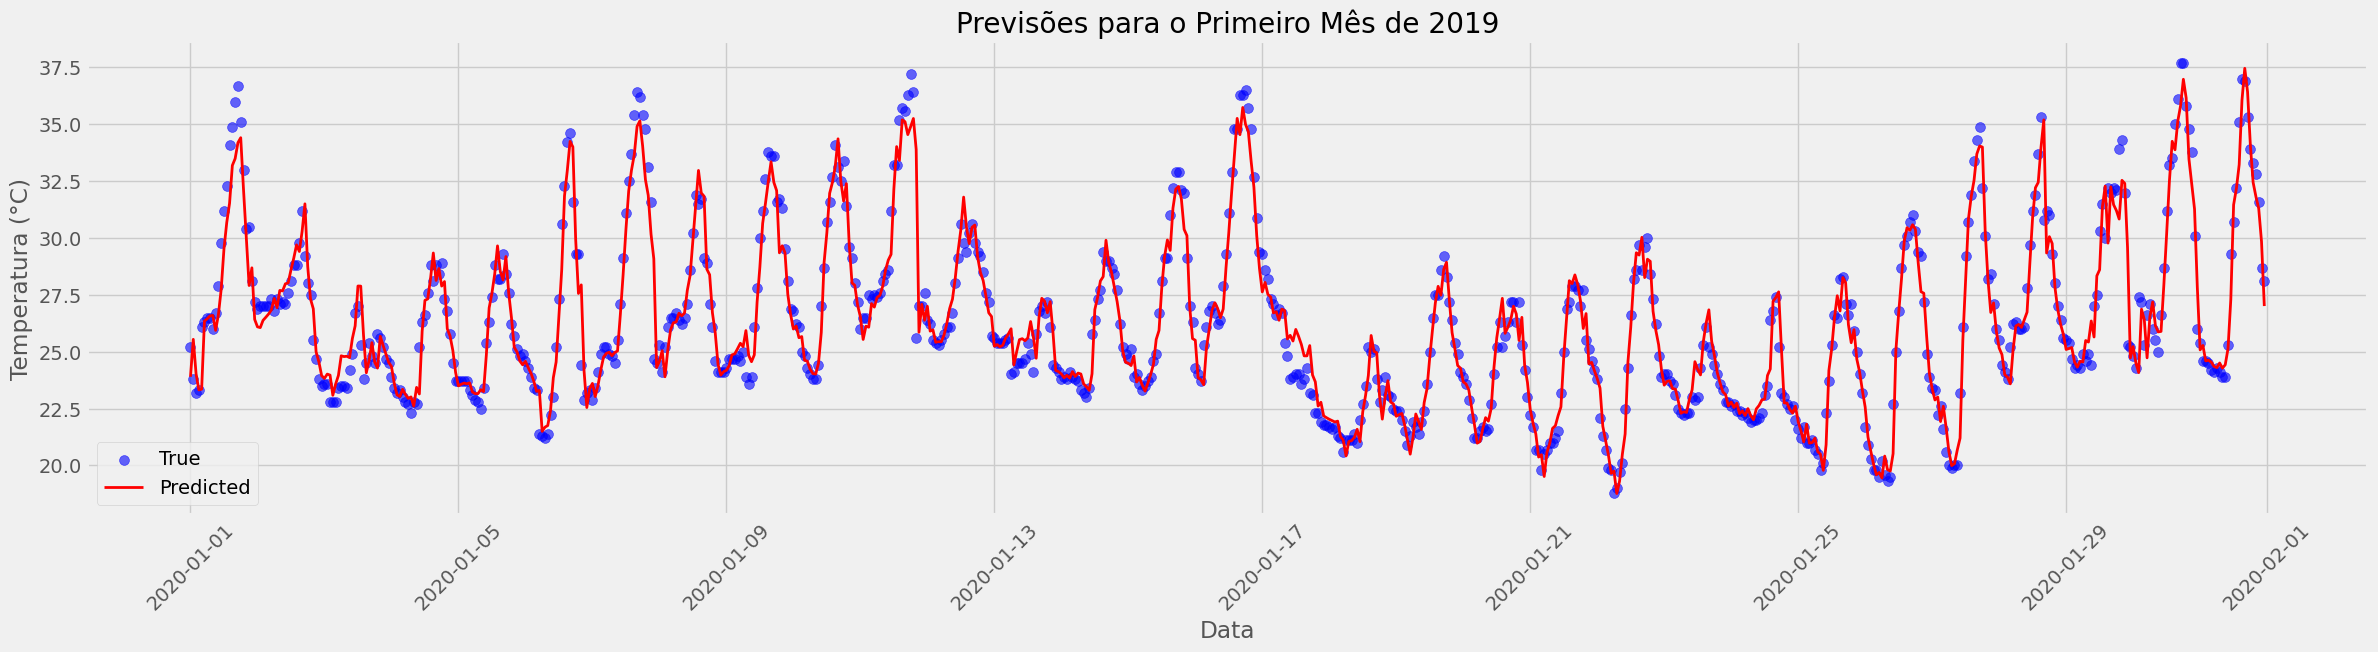

In [60]:
# Filtrando os dados de teste e as datas para o primeiro mês de 2019
mask = (dates >= '2020-01-01') & (dates < '2020-02-01')
dates_filtered = dates[mask]
y_test_filtered = y_test_rescaled[mask]
predictions_filtered = predictions_rescaled[mask]

# Plotando o gráfico de dispersão para o primeiro mês de 2019
plt.figure(figsize=(24, 6))  # Ajustando o tamanho (largura, altura)

# Scatter plot dos dados reais e previstos
plt.scatter(dates_filtered, y_test_filtered, label='True', marker='o', s=50, color='blue', alpha=0.6)
plt.plot(dates_filtered, predictions_filtered, label='Predicted', linewidth=2, color='red')

plt.xlabel('Data')  # Definindo o rótulo do eixo x como 'Data'
plt.ylabel('Temperatura (°C)')  # Definindo o rótulo do eixo y como 'Temperatura (°C)'
plt.title('Previsões para o Primeiro Mês de 2019')  # Adicionando um título ao gráfico
plt.legend()  # Mostrando a legenda
plt.tight_layout()  # Ajustando o layout para evitar que os rótulos se sobreponham
plt.xticks(rotation=45)  # Rotacionando os rótulos do eixo x para melhor visualização

plt.show()


In [61]:
test_dates = test.index[-len(y_test_rescaled):]
test_values = y_test_rescaled.flatten()

df_test = pd.DataFrame({'Data': test_dates, 'Valor_Real': test_values})
df_test['Prediction'] = predictions_rescaled.flatten()
df_test

Data  Valor_Real  Prediction
0     2019-01-02 00:00:00        25.1   24.818319
1     2019-01-02 01:00:00        25.2   24.562099
2     2019-01-02 02:00:00        24.6   24.820858
3     2019-01-02 03:00:00        24.0   24.293598
4     2019-01-02 04:00:00        23.9   23.885403
...                   ...         ...         ...
43795 2023-12-31 19:00:00        25.2   25.644806
43796 2023-12-31 20:00:00        24.8   24.985659
43797 2023-12-31 21:00:00        24.3   24.512589
43798 2023-12-31 22:00:00        23.9   23.885115
43799 2023-12-31 23:00:00        23.5   23.321087

[43800 rows x 3 columns]

In [62]:
# Calculate error metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'MSE': [mse],
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape]
}, index=['Final Model'])

results_df

MSE      RMSE       MAE      MAPE
Final Model  0.840153  0.916598  0.632594  2.704856

In [63]:
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\gfurt\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

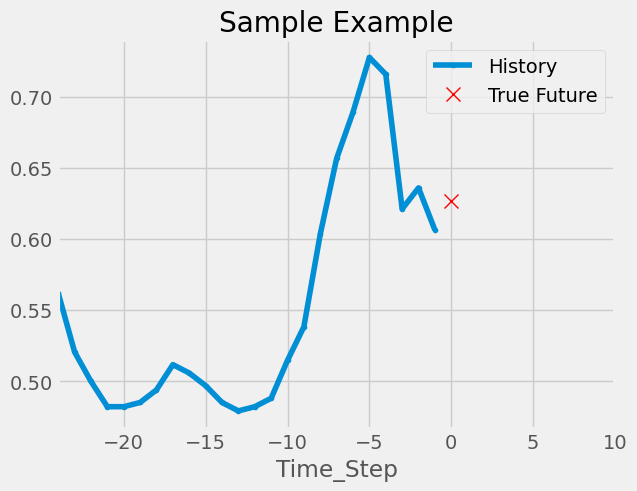

In [64]:
i = 20
plot_time_series([X_train[i], y_train[i]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from 'C:\\Users\\gfurt\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

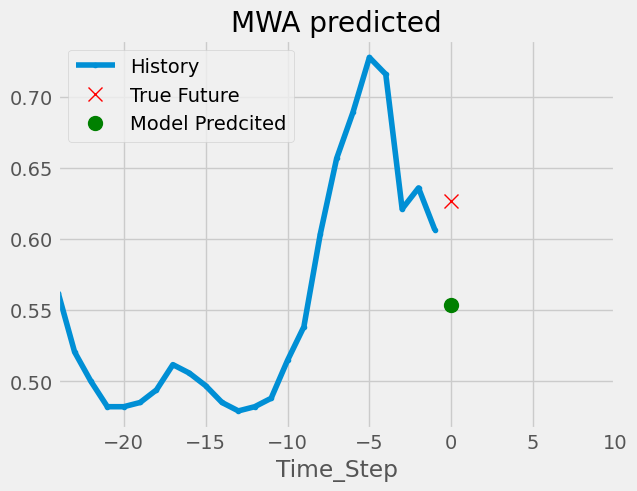

In [66]:
def MWA(history):
  return np.mean(history)

i = 20
plot_time_series([X_train[i], y_train[i] , MWA(X_train[i])] , 0 , 'MWA predicted')

In [70]:
import tensorflow as tf

val_uni = tf.data.Dataset.from_tensor_slices((X_test , y_test))
val_uni

<_TensorSliceDataset element_spec=(TensorSpec(shape=(24, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [72]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: strided_slice/

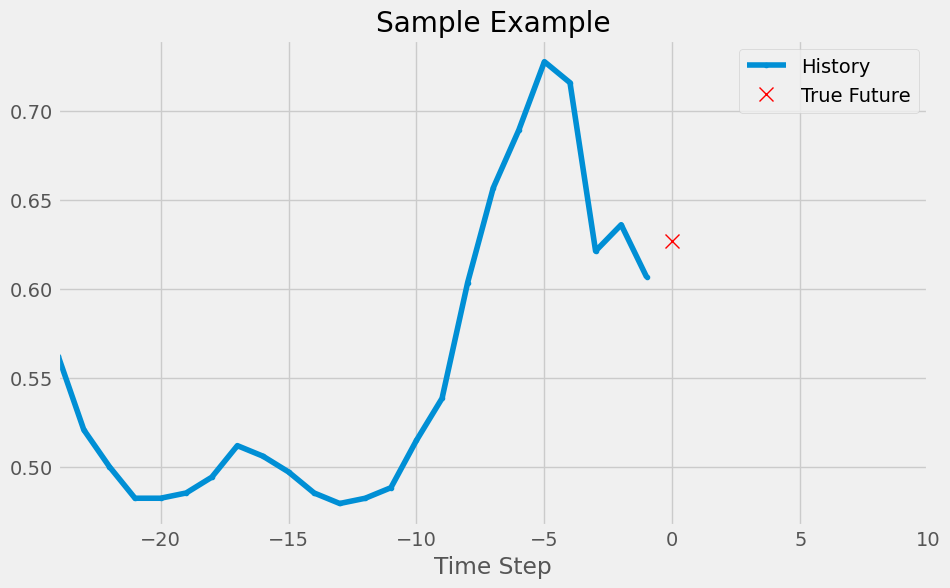

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


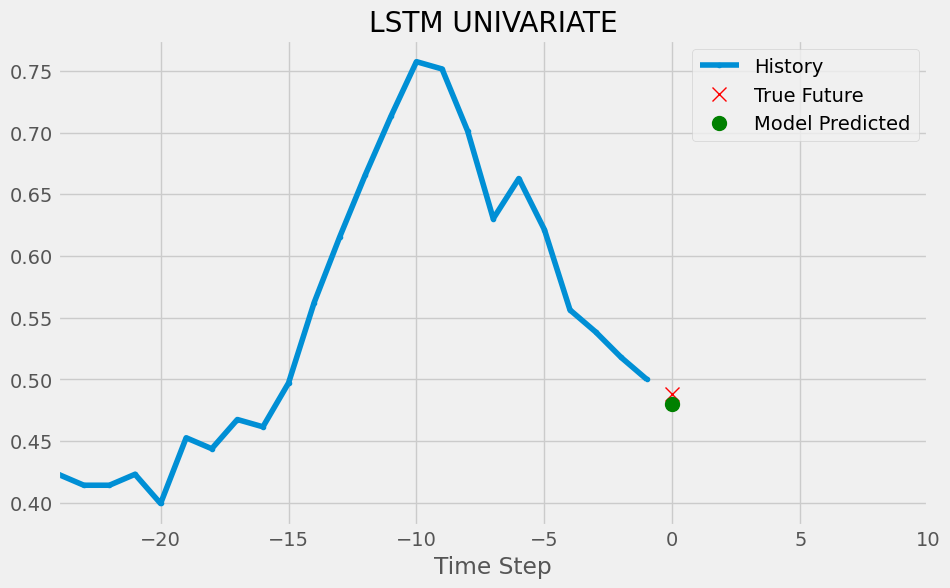

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


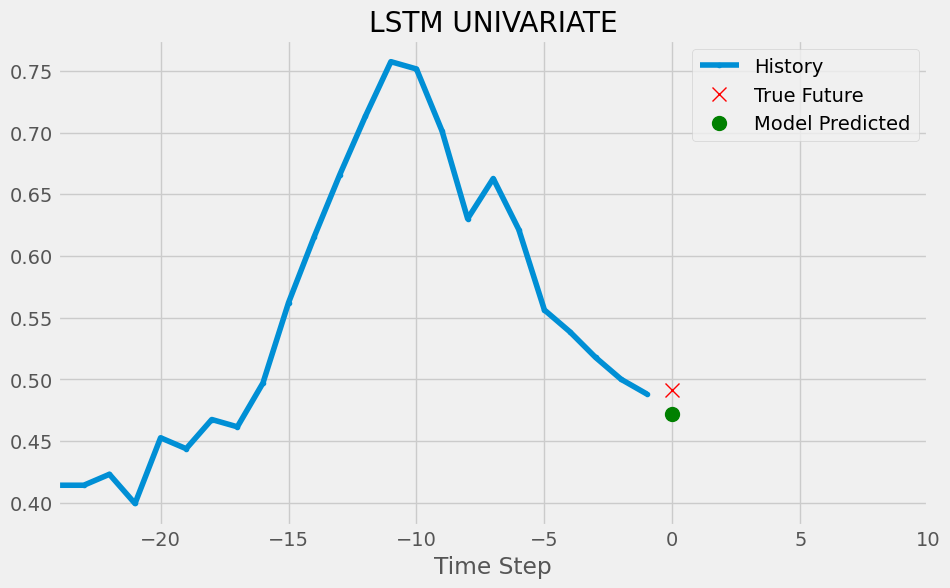

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


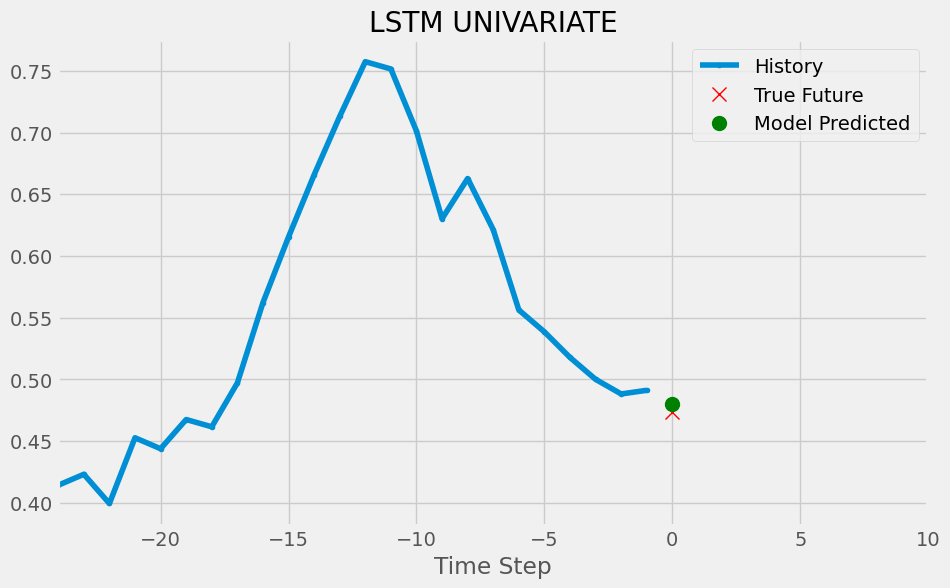

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


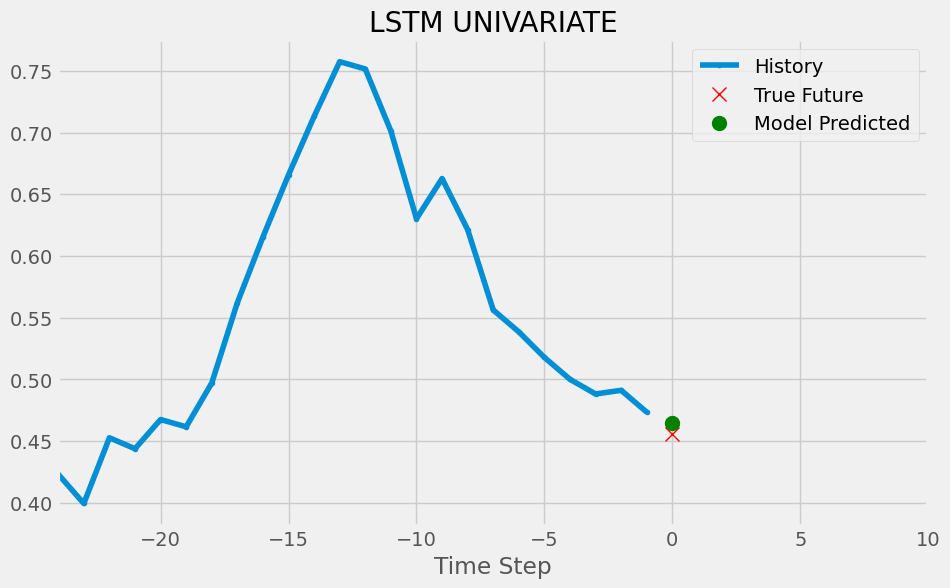

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


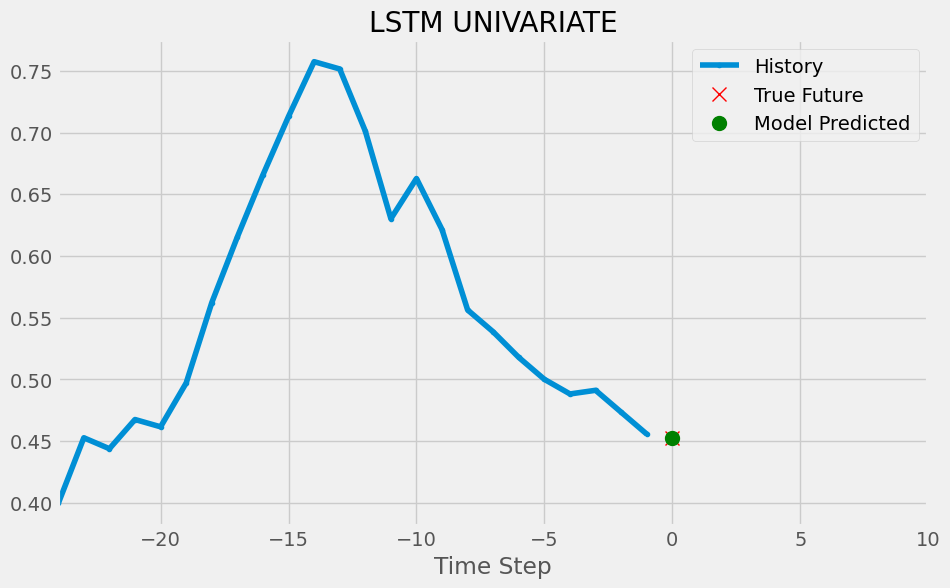

In [74]:
def create_time_steps(length):
    return list(range(-length, 0))

def plot_time_series(plot_data, delta, title):
    labels = ["History", 'True Future', 'Model Predicted']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel('Time Step')
    return plt

i = 20
plot_time_series([X_train[i], y_train[i]], 0, 'Sample Example').show()

def MWA(history):
    return np.mean(history)


val_uni = tf.data.Dataset.from_tensor_slices((X_test, y_test))

for i, j in val_uni.take(5):
    i = i.numpy().reshape((1, i.shape[0], i.shape[1]))  # Reshape input for model prediction
    prediction = model.predict(i)[0]
    plot_data = [i[0].flatten(), j.numpy().flatten(), prediction.flatten()]
    plot = plot_time_series(plot_data, 0, 'LSTM UNIVARIATE')
    plot.show()

In [78]:
# Supondo que você tenha dados de temperatura históricos até 2019
historical_data = train['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].values

# Definindo o número de passos temporais (número de horas anteriores usadas para prever o próximo ponto)
n_steps = 24  # Por exemplo, usando as últimas 24 horas para prever a próxima

# Criando sequências de entrada e saída
X, y = create_sequences(historical_data, n_steps)

# Reshape para o formato [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [82]:
# Suponha que seu modelo `model` já esteja treinado e `X` e `n_steps` estejam definidos corretamente

forecast = []
input_seq = X[-1].reshape((1, n_steps, 1))  # Última sequência de entrada disponível

for _ in range(35064):
    yhat = model.predict(input_seq)
    forecast.append(yhat[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], [[yhat[0, 0]]], axis=1)  # Atualiza a sequência de entrada com a nova previsão

# `forecast` agora contém as previsões para as próximas 35.064 horas


ValueError: params is required to have ndim 1 but has ndim 2